# **Settings**

In [1]:
# Since I'm working in a project folder called "crm-project"
# I'm setting this notebook to that project folder as the working directory 

import os

current_working_dir = os.path.normpath(os.getcwd()).split(os.path.sep)[-1]

if current_working_dir != 'crm_project':
    os.chdir('..')

## Libraries

In [2]:
# Data wrangling & statistics
import sidetable
import numpy as np
import pandas as pd
from scipy import stats

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Custom plot functions
from src.utils.eda import plot_chi2_heatmap, plot_chi2

# Machine Learning
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import scale, power_transform, OneHotEncoder

# Set transform output as pandas
from sklearn import set_config
set_config(transform_output="pandas")

## Plot settings

In [3]:
# Customizing plot default behaviour, please refer to:
# https://matplotlib.org/stable/tutorials/introductory/customizing.html

sns.set_theme(
    context='talk',
    style='ticks',
    font_scale=.75,
    palette=['#16a3ae', '#f69f38'], # Betsson colors ;)
    rc={
        'figure.figsize': (6,4),
        'axes.grid': True,
        'grid.alpha': .3,
        'axes.titlesize': 'large',
        'axes.titleweight': 'bold',
        'axes.titlepad': 30,
        'axes.labelpad': 15
    }
)

## Functions

In [4]:
def plot_heatmap(df_corr, mask_threshold=None, annot=False, title=''):
    # Create mask
    mask = np.zeros(df_corr.shape).astype(bool)
    mask[np.triu_indices_from(mask)] = True

    # Show only significant correlations given a target threshold
    if mask_threshold:
        mask = mask | (df_corr.abs() < mask_threshold).values

    sns.heatmap(
        df_corr, cmap='RdBu_r', mask=mask, square=False, center=0, vmin=-1, vmax=1, linewidths=1,
        annot=annot, fmt=".2f", annot_kws={"fontsize":"small"},
        cbar=True, cbar_kws={'orientation':'vertical', 'shrink': .5}
    )

    plt.title(title, weight='bold')

## Load datasets

In [5]:
# Load datasets, specifying the customer IDs as index
df_train = pd.read_csv('data/train_set.csv', index_col='mk_CurrentCustomer')
df_test = pd.read_csv('data/test_set.csv', index_col='mk_CurrentCustomer')
df_customer_country = pd.read_csv('data/customer_country.csv', index_col='mk_CurrentCustomer')

# Convert date columns to date specifying the format (it's much faster when specifying it)
df_train['ScoreDate'] = pd.to_datetime(df_train['ScoreDate'], format='%d/%m/%Y %H:%M')

# Merging the datasets
# Note: Since there are no duplicated IDs (see next cells), so it's safe to merge it
df = df_train.join(df_customer_country, how='left')

# Show quantity of rows, columns, and first rows
print(df.shape)
display(df.head())

(55415, 270)


,ScoreDate,days_g10,days_g9,days_g8,days_g7,days_g6,days_g5,days_g4,days_g3,days_g2,...,days_since_last_SE_GI,SE_GI_max_datediff,SE_GI_min_datediff,SE_GI_avg_datediff,SE_GI_std_datediff,days_since_last_SE_GI_wrt_max,days_since_last_SE_GI_wrt_min,days_since_last_SE_GI_wrt_avg,days_since_last_SE_GI_wrt_std,country
mk_CurrentCustomer,,,,,,,,,,,,,,,,,,,,,
10871718,2019-08-29,2,0,2,3,3,3,2,5,4,...,15,-1,-1,-1,-1.0,-1,-1,-1,-1.0,France
6818142,2019-08-29,4,3,2,5,3,3,5,4,3,...,-1,-1,-1,-1,-1.0,-1,-1,-1,-1.0,France
15585115,2019-08-29,4,1,2,4,7,4,1,0,0,...,18,-1,-1,-1,-1.0,-1,-1,-1,-1.0,Spain
12544601,2019-08-29,2,3,7,4,1,2,0,2,0,...,-1,-1,-1,-1,-1.0,-1,-1,-1,-1.0,Malta
14695611,2019-08-29,5,1,4,4,3,4,4,3,4,...,-1,-1,-1,-1,-1.0,-1,-1,-1,-1.0,Italy


## Configs

In [6]:
FEATURE_DESCRIPTIONS = {
    "days_g1/2/3/4/5/6/7/8/3/10": "Number of days with activity during week 1/2/3/4/5/6/7/8/9/10.",
    "ro_g1/2/3/4/5/6/7/8/9/10": "Number of game rounds during week 1/2/3/4/5/6/7/8/9/10.",
    "to_g1/2/3/4/5/6/7/8/9/10": "Total turnover amount in EUR during week 1/2/3/4/5/6/7/8/9/10.",
    "gw_g1/2/3/4/5/6/7/8/9/10": "Total game win amount in EUR during week 1/2/3/4/5/6/7/8/9/10.",
    "mar_gl/2/3/4/5/6/7/8/9/10": "Total margin calculated as [gw_g}/(1+(to_g]) during week 1/2/3/4/5/6/7/8/9/10.",
    "GOC_r0_g1/2/3/4/5/6/7/8/9/10": "Number of GOC game rounds during week 1/2/3/4/5/6/7/8/9/10.",
    "GOC_to_g1/2/3/4/5/6/7/8/9/10": "Total GOC turnover amount in EUR during week 1/2/3/4/5/6/7/8/9/10.",
    "GOC_dist_gm_g1/2/3/4/5/6/7/8/9/10": "Number of GOC distinct game play days during week 1/2/3/4/5/6/7/8/9/10.",
    "SB_ro_g1/2/3/4/5/6/7/8/9/10": "Number of $8 game rounds during week 1/2/3/4/5/6/7/8/9/10.",
    "SB_to_g1/2/3/4/5/6/7/8/9/10": "Total SB turnover amount in EUR during week 1/2/3/4/5/6/7/8/9/10.",
    "with_cnl_g1/2/3/4/5/6/7/8/9/10": "Number of cancelled withdrawals during week 1/2/3/4/5/6/7/8/9/10.",
    "with_cnt_g1/2/3/4/5/6/7/8/3/10": "Number of successful withdrawals during week 1/2/3/4/5/6/7/8/9/10.",
    "with_sum_g1/2/3/4/5/6/7/8/9/10": "Total successful withdrawal amount in EUR during week 1/2/3/4/5/6/7/8/9/10.",
    "succ_dep_g1/2/3/4/5/6/7/8/9/10": "Total successful deposit amount in EUR during week 1/2/3/4/5/6/7/8/9/10.",
    "unsucc_dep_g1/2/3/4/5/6/7/8/9/10": "Total unsuccessful deposit amount in EUR during week 1/2/3/4/5/6/7/8/9/10.",
    "succ_dep_cnt_g1/2/3/4/5/6/7/8/9/10": "Number of successful deposits during week 1/2/3/4/5/6/7/8/9/10.",
    "unsucc_dep_cnt_g1/2/3/4/5/6/7/8/9/10": "Number of unsuccessful deposits during week 1/2/3/4/5/6/7/8/9/10.",
    "pm_sum_g1/2/3/4/5/6/7/8/8/10": "Total number of payment methods during week 1/2/3/4/5/6/7/8/9/10.",
    "pm_avg_g1/2/3/4/5/6/7/8/9/10": "Average number of daily payment methods during week 1/2/3/4/5/6/7/8/9/10.",
    "ini_bon_g1/2/3/4/S/6/7/8/9/10": "Total bonus amount in EUR during week 1/2/3/4/5/6/7/8/9/10.",
    "ini_bon_cnt_gi/2/3/4/5/6/7/8/9/10": "Number of bonuses during week 1/2/3/4/5/6/7/8/9/10.",
    "bon_wrt_succdep_g1/2/3/4/5/6/7/8/9/10": "Total bonus amount vs total successful deposit amount calculated as [ini_bon_g]/(1+[succ_dep_g]) during week 1/2/3/4/5/6/7/8/9/10",
    "turnover_last_1/2/3/5/10/20/70days": "Turnover amount in EUR in the last 1/2/3/5/10/20/70 days.",
    "to_l1_l5/10/20/70": "Turnover of the last day vs turnover in the last 5/10/20/70 days.",
    "to_l2_I5/10/20/70": "Turnover in the last 2 days vs turnover in the last 5/10/20/70 days.",
    "to_l3_l10/20/70": "Turnover in the last 3 days vs turnover in the last 10/20/70 days.",
    "to_l5_l10/20/70": "Turnover in the last 5 days vs turnover in the last 10/20/70 days.",
    "dwcanc_last_1/2/3/5day": "Total amount of cancelled withdrawals in the last 1/2/3/5 days.",
    "w_canc_count_ratio_1/2/3/5day": "Total amount of cancelled withdrawals vs number of cancelled withdrawals in the last 1/2/3/5 days.",
    "dwcount_last": "Total count of cancelled withdrawals in the last 1/2/3/5 days ??",
    "SE_total": "Number of times the customer was self excluded in the past.",
    "GI_total": "Number of times the customer was tagged as gambling issue in the past.",
    "SE_GI_total": "Number of times the customer was either self excluded or tagged as gambling issue in the past.",
    "SE_GI_total_70days": "Number of times the customer was either self excluded or tagged as gambling issue in the past 70 days.",
    "SE_GI_wrt_days_7Odays": "Number of times the customer was either self excluded or tagged as gambling issue in the past 70 days vs total active days in the past 70 days",
    "SE_GI_max/min/avg/std_datediff": "Min/max/avg/std of distance in days between multiple self-exclusion events.",
    "days_since_last_SE_GI_wrt_max/min/avg/std": "Days since last self-exclusion/gambling issue event vs min/max/avg/std of distance in days between multiple self-exclusion events."
}

In [7]:
FEATURE_COLUMNS = dict(
    days_g = [f'days_g{i}' for i in range(1,11)],
    ro_g = [f'ro_g{i}' for i in range(1,11)],
    to_g = [f'to_g{i}' for i in range(1,11)],
    gw_g = [f'gw_g{i}' for i in range(1,11)],
    mar_g = [f'mar_g{i}' for i in range(1,11)],
    GOC_ro_g = [f'GOC_ro_g{i}' for i in range(1,11)],
    GOC_to_g = [f'GOC_to_g{i}' for i in range(1,11)],
    GOC_dist_gm_g = [f'GOC_dist_gm_g{i}' for i in range(1,11)],
    SB_ro_g = [f'SB_ro_g{i}' for i in range(1,11)],
    SB_to_g = [f'SB_to_g{i}' for i in range(1,11)],
    with_cnl_g = [f'with_cnl_g{i}' for i in range(1,11)],
    with_cnt_g = [f'with_cnt_g{i}' for i in range(1,11)],
    with_sum_g = [f'with_sum_g{i}' for i in range(1,11)],
    succ_dep_g = [f'succ_dep_g{i}' for i in range(1,11)],
    unsucc_dep_g = [f'unsucc_dep_g{i}' for i in range(1,11)],
    succ_dep_cnt_g = [f'succ_dep_cnt_g{i}' for i in range(1,11)],
    unsucc_dep_cnt_g = [f'unsucc_dep_cnt_g{i}' for i in range(1,11)],
    pm_sum_g = [f'pm_sum_g{i}' for i in range(1,11)],
    pm_avg_g = [f'pm_avg_g{i}' for i in range(1,11)],
    ini_bon_g = [f'ini_bon_g{i}' for i in range(1,11)],
    ini_bon_cnt_g = [f'ini_bon_cnt_g{i}' for i in range(1,11)],
    bon_wrt_succdep_g = [f'bon_wrt_succdep_g{i}' for i in range(1,11)],
    turnover_last = [f'turnover_last_{i}day' if i==1 else f'turnover_last_{i}days' for i in (1,2,3,5,10,20,70)],
    to_l1_l = [f'to_l1_l{i}' for i in (5,10,20,70)],
    to_l2_l = [f'to_l2_l{i}' for i in (5,10,20,70)],
    to_l3_l = [f'to_l3_l{i}' for i in (10,20,70)],
    to_l5_l = [f'to_l5_l{i}' for i in (10,20,70)],
    dwcanc_last = [f'dwcanc_last_{i}day' if i==1 else f'dwcanc_last_{i}days' for i in (1,2,3,5)],
    w_canc_count_ratio = [f'w_canc_count_ratio_l{i}' for i in (1,2,3,5)],
    dwcount_last = [f'dwcount_last_{i}day' if i==1 else f'dwcount_last_{i}days' for i in (1,2,3,5)],
    SE_GI_features = ['SE_total', 'GI_total', 'SE_GI_total', 'SE_GI_total_70days', 'SE_GI_wrt_days_70days'],
    SE_GI_stats = ['SE_GI_max_datediff', 'SE_GI_min_datediff', 'SE_GI_avg_datediff', 'SE_GI_std_datediff'],
    days_since_last_SE_GI_wrt_stats = ['days_since_last_SE_GI', 'days_since_last_SE_GI_wrt_max', 'days_since_last_SE_GI_wrt_min', 'days_since_last_SE_GI_wrt_avg', 'days_since_last_SE_GI_wrt_std']
)

# **EDA**

## Quality checks

In [8]:
# Checking duplicated customers on both files (that's how we know it's safe to merge them)
df_train.index.duplicated().any() | df_customer_country.index.duplicated().any()

False

In [9]:
# Checking if amount of rows from the train data remains
df_train.shape[0] == df.shape[0]

True

In [10]:
# Check missing values
df.isna().any().any()

False

In [11]:
# Check missing in the test set
df_test.isna().any().any()

False

In [12]:
# Basic data info
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55415 entries, 10871718 to 15533687
Columns: 270 entries, ScoreDate to country
dtypes: datetime64[ns](1), float64(137), int64(131), object(1)
memory usage: 116.6+ MB


In [13]:
# Check target proportion
df.stb.freq(['target'])

,target,count,percent,cumulative_count,cumulative_percent
0,0,54474,98.301904,54474,98.301904
1,1,941,1.698096,55415,100.000000


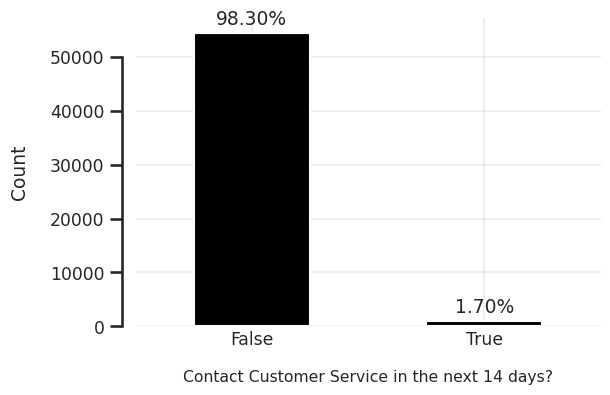

In [14]:
# Plot target proportion
target_count = df['target'].astype(bool).astype(str).value_counts()
target_pct = df['target'].astype(bool).astype(str).value_counts(normalize=True)

fig,ax = plt.subplots()

target_count.plot.bar(color='black', ax=ax)
plt.xlabel('Contact Customer Service in the next 14 days?', size='small')
plt.ylabel('Count')
plt.xticks(rotation=0)

for p,l in zip(ax.patches,ax.get_xticklabels()):
    height = p.get_height()
    pct_text = target_pct[l.get_text()]
    ax.annotate(
        f'{pct_text:.2%}', xy=(p.get_x() + p.get_width() / 2, height), xytext=(0, 3),
        textcoords="offset points", ha='center', va='bottom'
    )

ax.tick_params(axis='x', which='both', length=0)
    
sns.despine(bottom=True, trim=True, offset=10)
plt.show()

There are no missing values, no duplicated rows, and the target data is **highly imbalanced**!

## Constant & quasi-constant features

In [15]:
# List numeric and categorical features
numeric_features = df.drop(columns=['ScoreDate','country','target']).columns.tolist()
categorical_features = ['country']

# Split numeric and categorical features
df_num = df[numeric_features]
df_cat = df[categorical_features]

In [16]:
# Check columns with constant value (we'll remove them from analysis/modeling)
constant_features = df.agg('nunique').eq(1)
constant_features[constant_features].index.tolist()

['ScoreDate']

In [17]:
# Check columns with quasi-constant values (we'll remove them from analysis/modeling)
quasi_constant_features = df_num.var()<=0.01
quasi_constant_features[quasi_constant_features].index.tolist()

['to_l1_l70', 'GI_total', 'SE_GI_wrt_days_70days']

# Univariate Analysis

In [18]:
# Descriptive stats for original data
df_num.describe(percentiles=[.25,.5,.75,.99,.995])

,days_g10,days_g9,days_g8,days_g7,days_g6,days_g5,days_g4,days_g3,days_g2,days_g1,...,SE_GI_wrt_days_70days,days_since_last_SE_GI,SE_GI_max_datediff,SE_GI_min_datediff,SE_GI_avg_datediff,SE_GI_std_datediff,days_since_last_SE_GI_wrt_max,days_since_last_SE_GI_wrt_min,days_since_last_SE_GI_wrt_avg,days_since_last_SE_GI_wrt_std
count,55415.000000,55415.000000,55415.000000,55415.000000,55415.000000,55415.000000,55415.000000,55415.000000,55415.000000,55415.000000,...,55415.000000,55415.000000,55415.000000,55415.000000,55415.000000,55415.000000,55415.000000,55415.000000,55415.00000,55415.000000
mean,3.249283,3.160985,2.887774,2.694090,2.534296,2.552251,2.498962,2.496147,2.431941,2.355517,...,0.000018,105.083335,38.064892,16.316340,24.530596,9.667549,-0.561491,0.639358,-0.47590,-0.350669
std,2.207593,2.294607,2.380197,2.384776,2.371940,2.394406,2.389054,2.397165,2.392237,2.387041,...,0.004248,365.985696,180.242843,110.364582,127.761708,67.788509,8.291379,19.393687,9.02643,24.172456
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000
25%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000
50%,3.000000,3.000000,3.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000
75%,5.000000,5.000000,5.000000,5.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,...,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000
99%,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,...,0.000000,2000.000000,935.720000,466.000000,622.000000,301.649684,4.000000,26.860000,6.00000,7.185253
99.5%,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,...,0.000000,2295.790000,1221.860000,764.000000,866.860000,480.294201,9.000000,64.930000,13.00000,15.066350
max,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,...,1.000000,5945.000000,5015.000000,4158.000000,4158.000000,2741.840987,845.000000,1005.000000,872.00000,4531.044913


In [19]:
# Descriptive stats for features with the highest range (to highlight outliers)
highest_ranges = df_num.apply(scale).apply(lambda x: x.max() - x.min()).sort_values(ascending=False).head(10).index
df_num[highest_ranges].describe(percentiles=[.25,.5,.75,.99,.995])

,gw_g8,gw_g7,SE_GI_wrt_days_70days,mar_g3,bon_wrt_succdep_g8,unsucc_dep_g8,SB_to_g8,gw_g2,SB_to_g7,with_sum_g8
count,55415.000000,55415.000000,55415.000000,55415.000000,55415.000000,55415.000000,5.541500e+04,55415.000000,5.541500e+04,55415.000000
mean,-86.992825,-85.059200,0.000018,-0.092597,0.971746,173.537111,4.237183e+02,-91.566777,3.586638e+02,222.618962
std,2582.774584,2532.532325,0.004248,2.330595,32.793466,4083.854676,8.789732e+03,1517.749186,6.627518e+03,2465.312225
min,-163365.400000,-85766.660000,0.000000,-0.999800,0.000000,0.000000,0.000000e+00,-176602.780000,0.000000e+00,0.000000
25%,-103.864700,-100.050000,0.000000,-0.202600,0.000000,0.000000,0.000000e+00,-85.464550,0.000000e+00,0.000000
50%,-14.950000,-11.600000,0.000000,-0.024500,0.000000,0.000000,0.000000e+00,-3.100000,0.000000e+00,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.053100,30.000000,4.826810e+01,0.000000,2.266515e+01,65.000000
99%,1378.881476,1304.765296,0.000000,0.814158,16.044000,2758.542340,6.758736e+03,1199.805400,6.206709e+03,3362.277996
99.5%,2372.264353,2463.224288,0.000000,1.289123,32.545768,4639.725315,1.188462e+04,2235.062937,1.066179e+04,5379.028963
max,478379.799800,513582.087500,1.000000,541.421200,7152.580000,887001.000000,1.853940e+06,142312.570000,1.350032e+06,479756.089000


In [20]:
# Categorical descriptive stats
df_cat.describe()

,country
count,55415
unique,7
top,France
freq,27276


In [21]:
# Country frequencies
df_cat.stb.freq(['country'])

,country,count,percent,cumulative_count,cumulative_percent
0,France,27276,49.221330,27276,49.221330
1,Germany,11006,19.861048,38282,69.082378
2,Malta,5662,10.217450,43944,79.299829
3,Italy,5606,10.116394,49550,89.416223
4,Spain,5563,10.038798,55113,99.455021
5,Greece,249,0.449337,55362,99.904358
6,Portugal,53,0.095642,55415,100.000000


## Bivariate Analysis

### Numeric features

#### Visual analysis

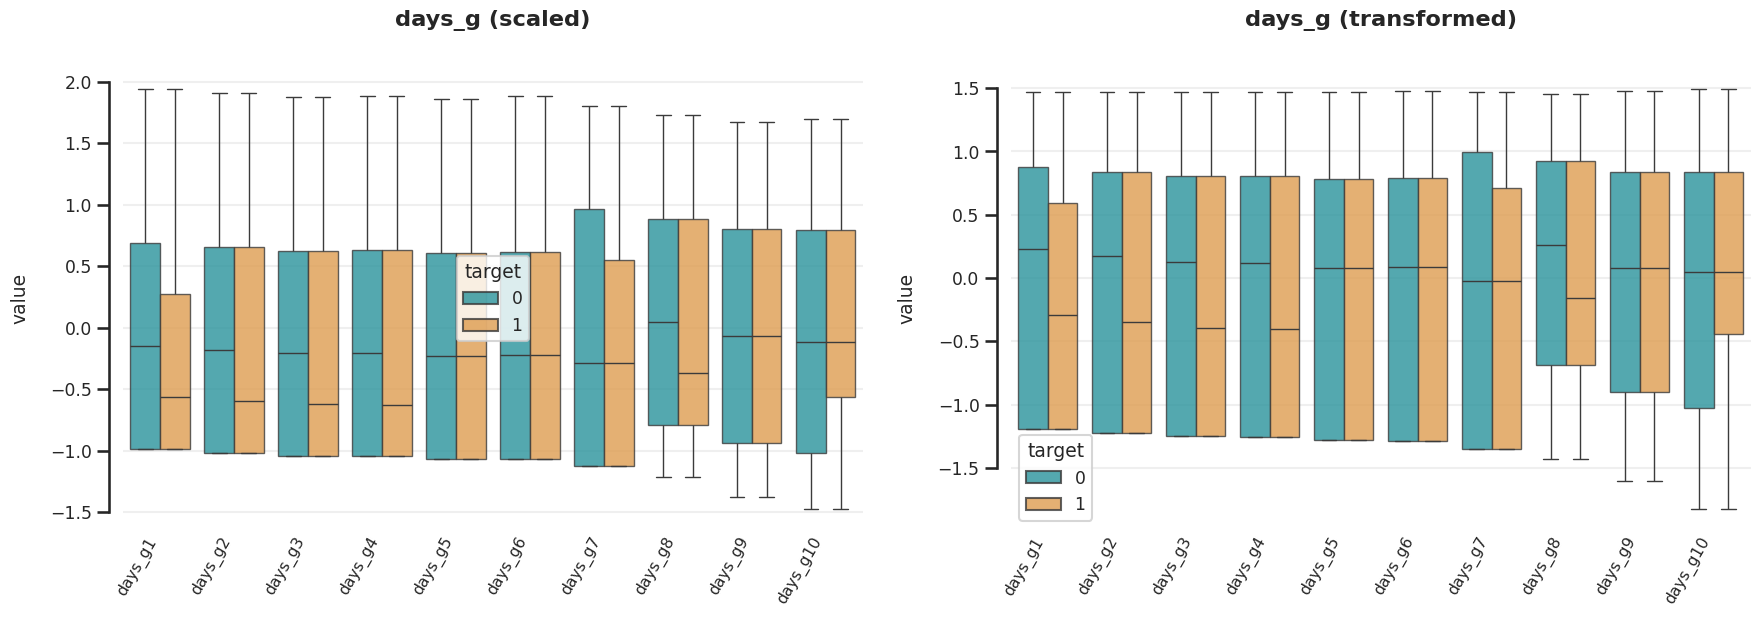

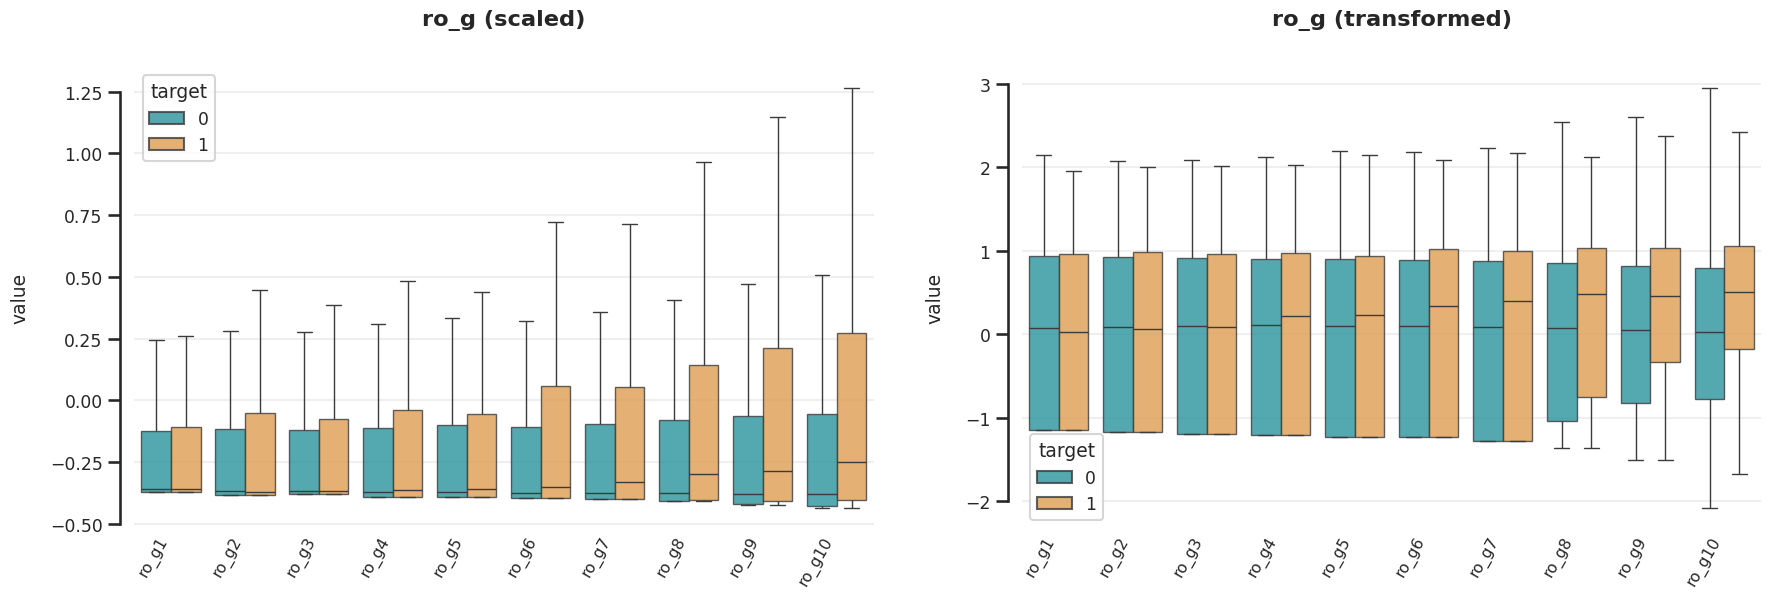

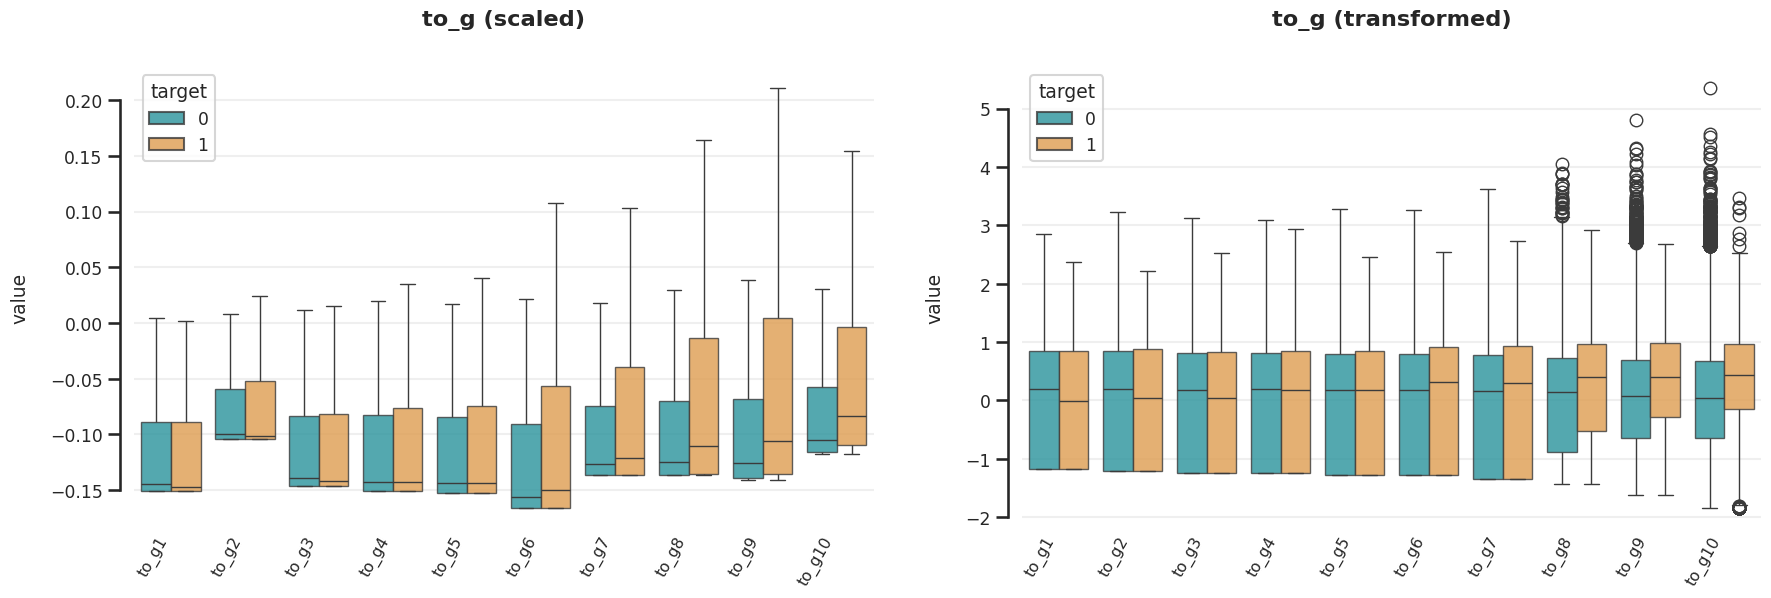

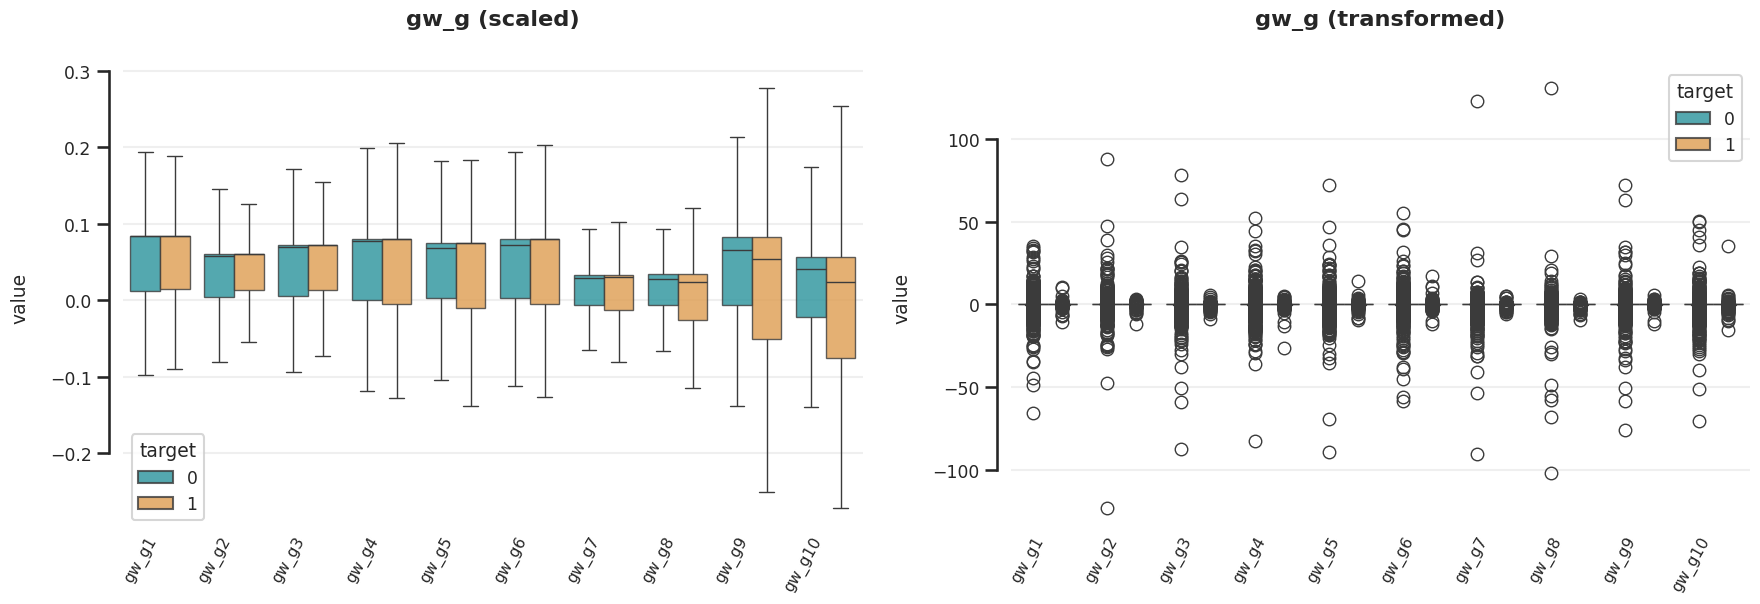

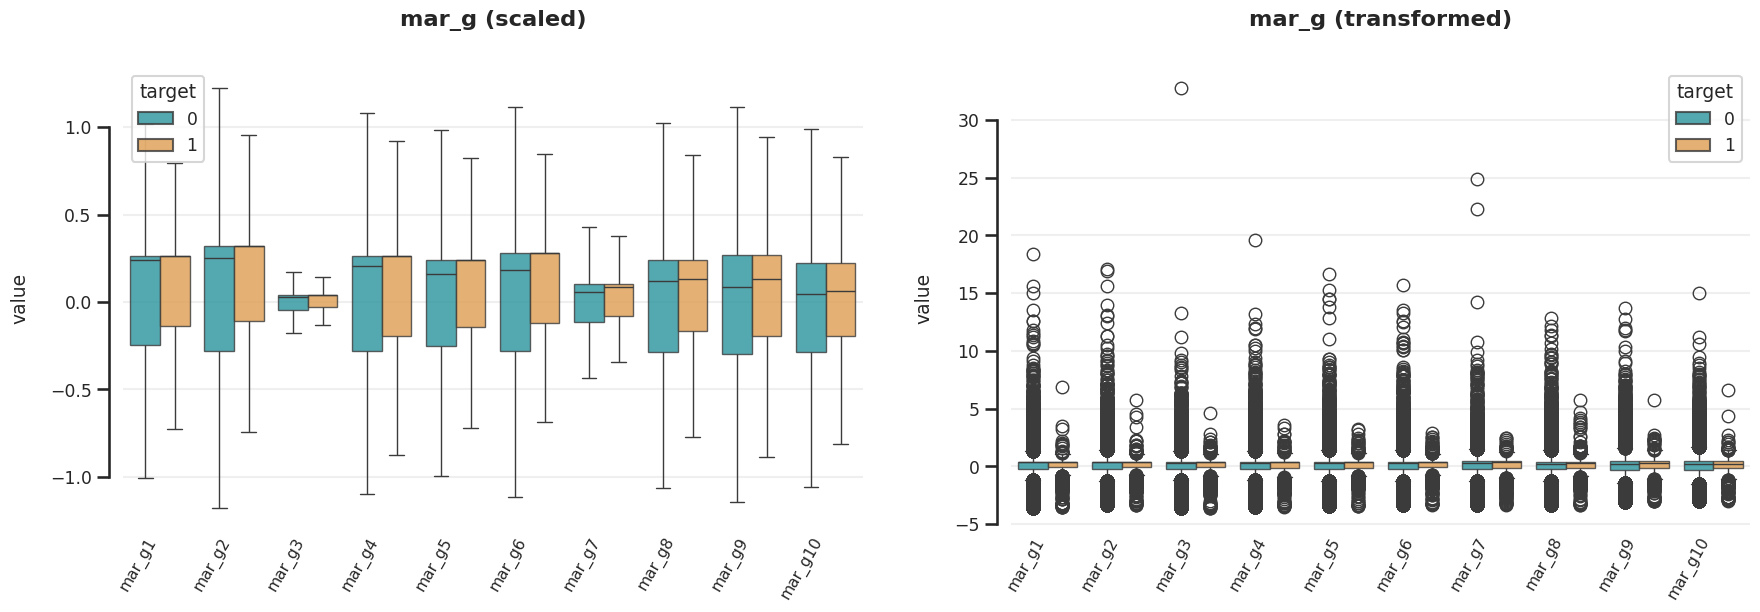

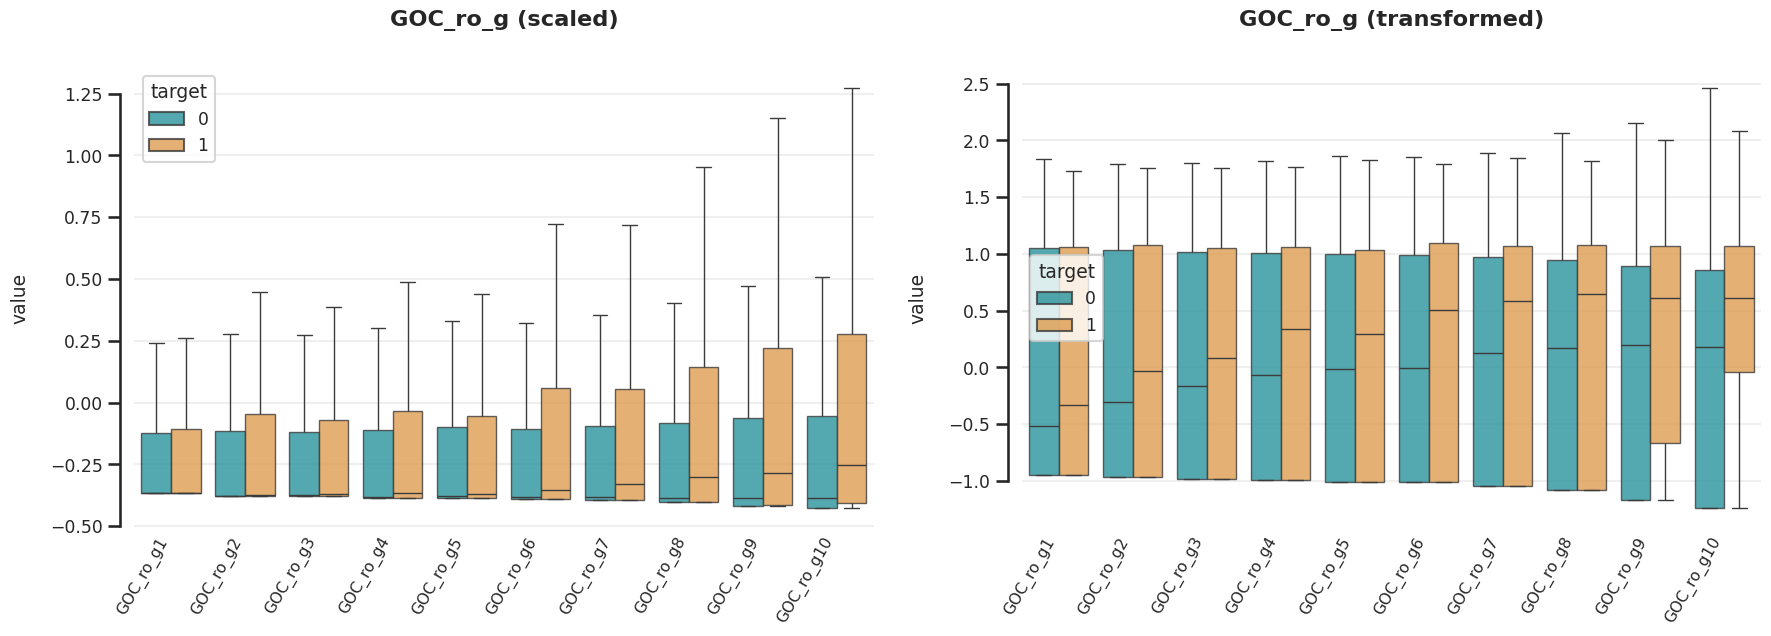

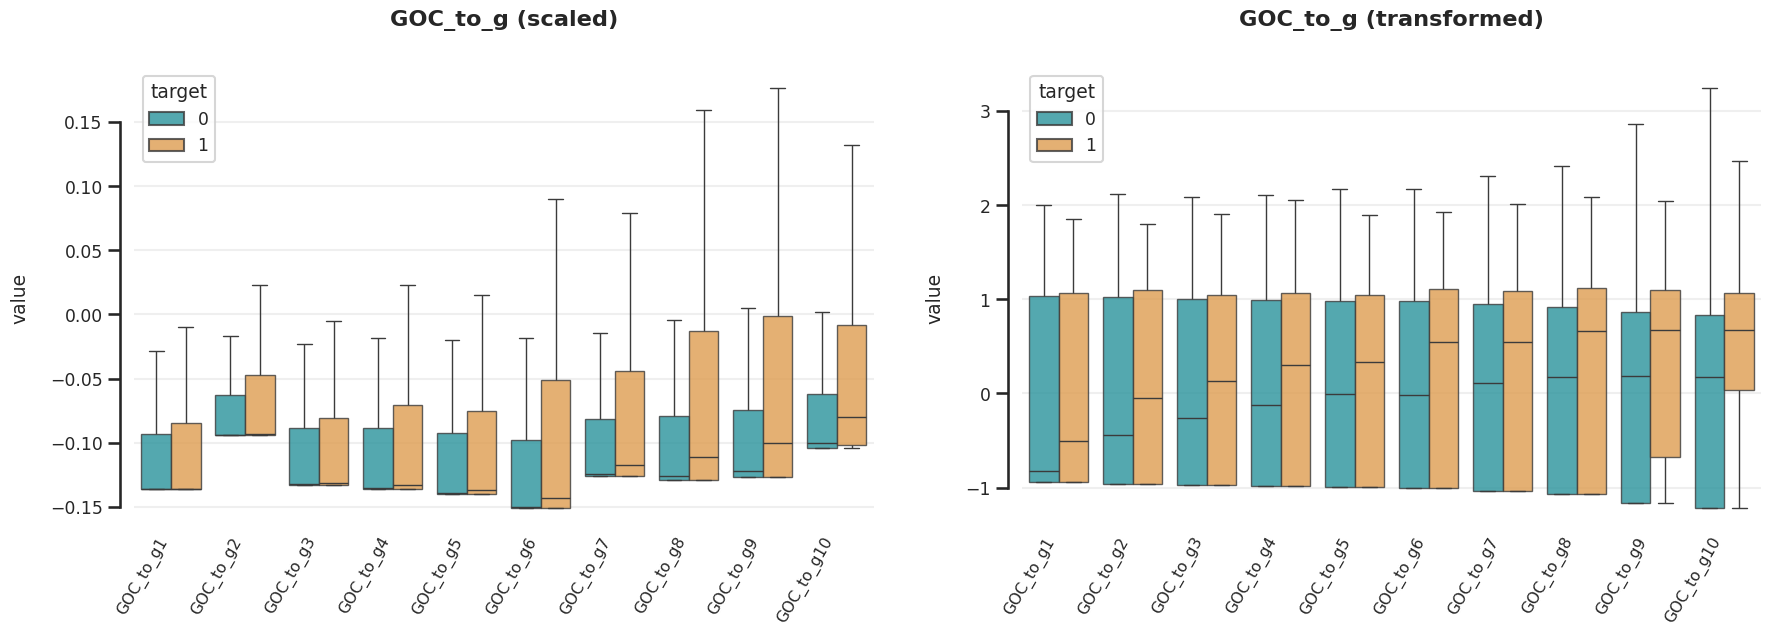

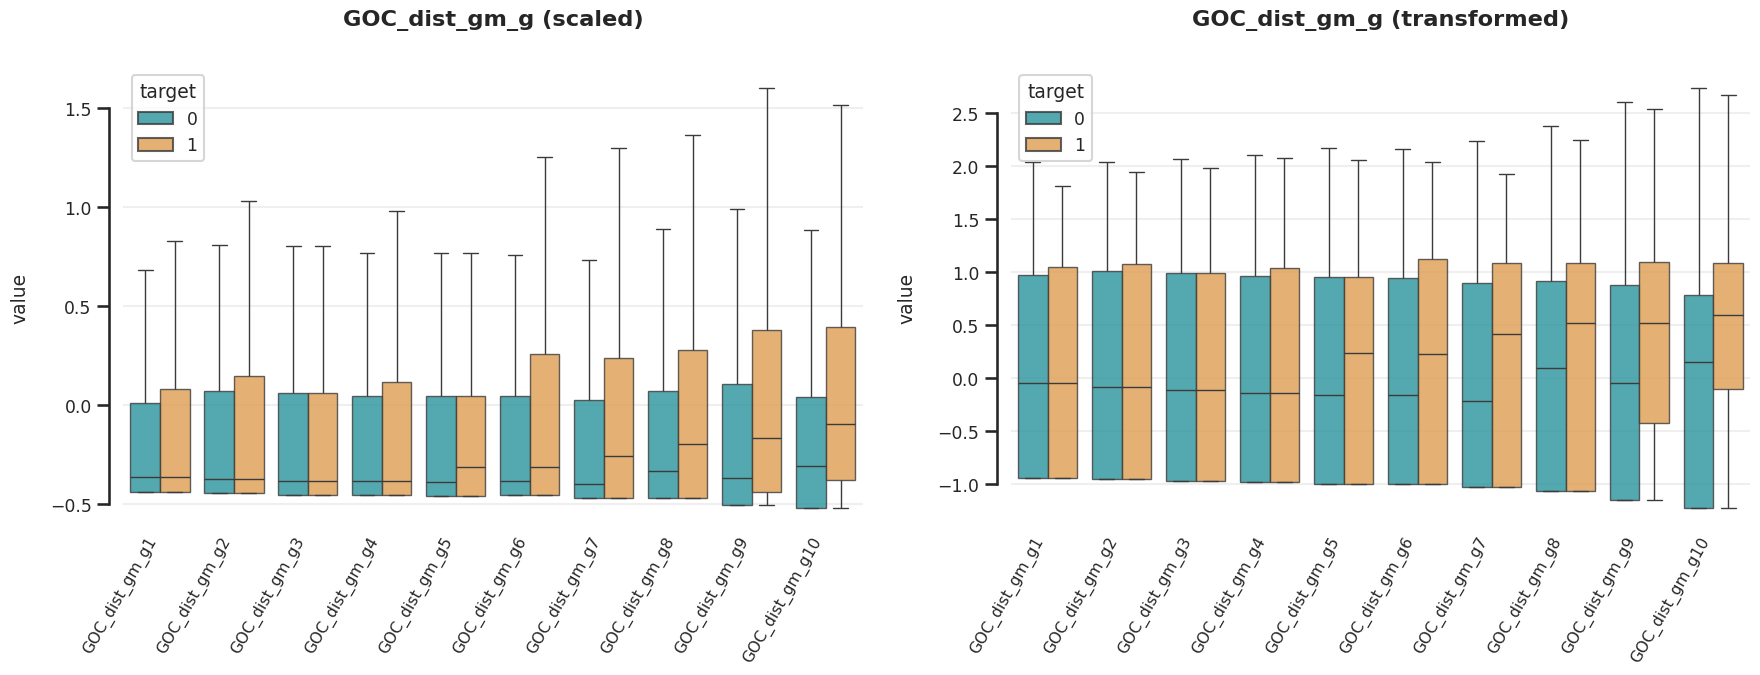

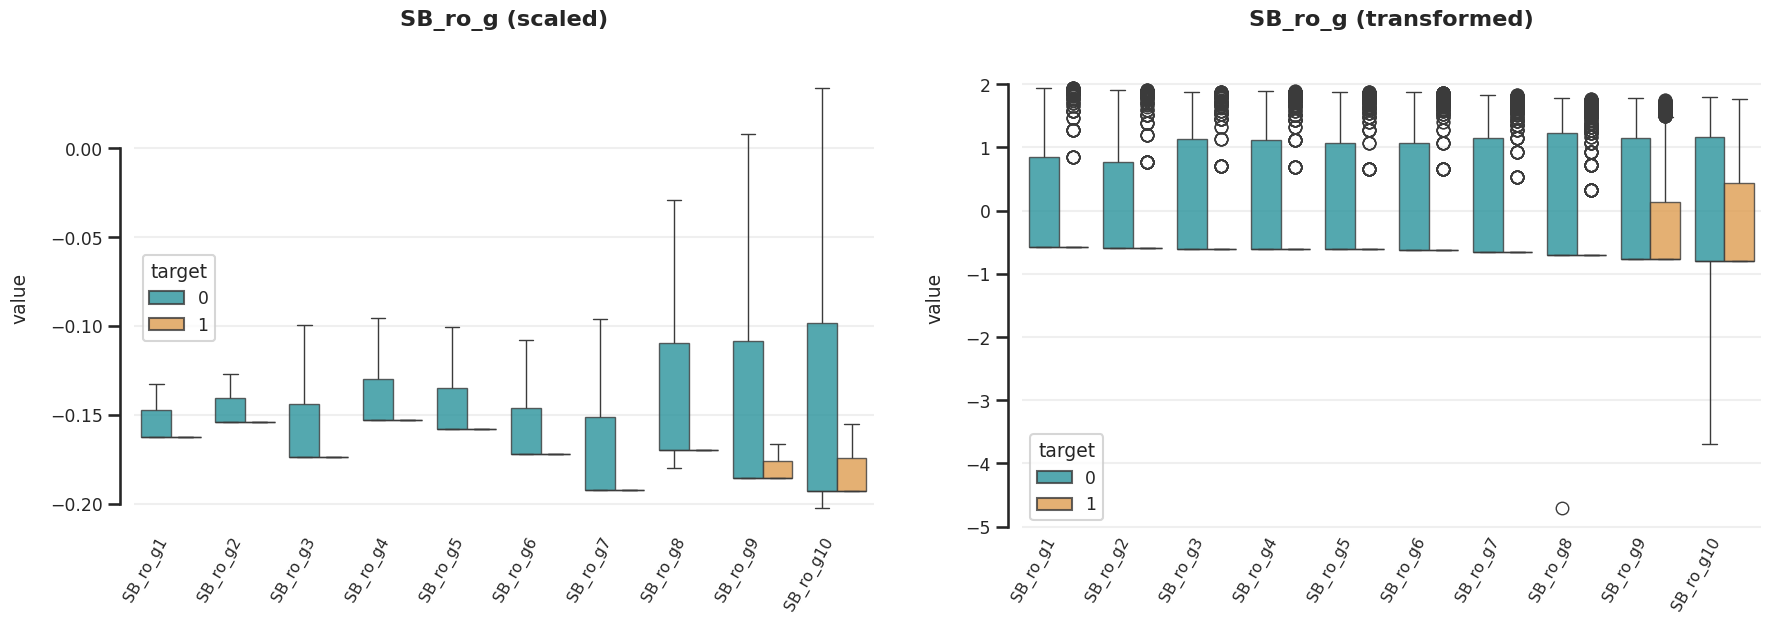

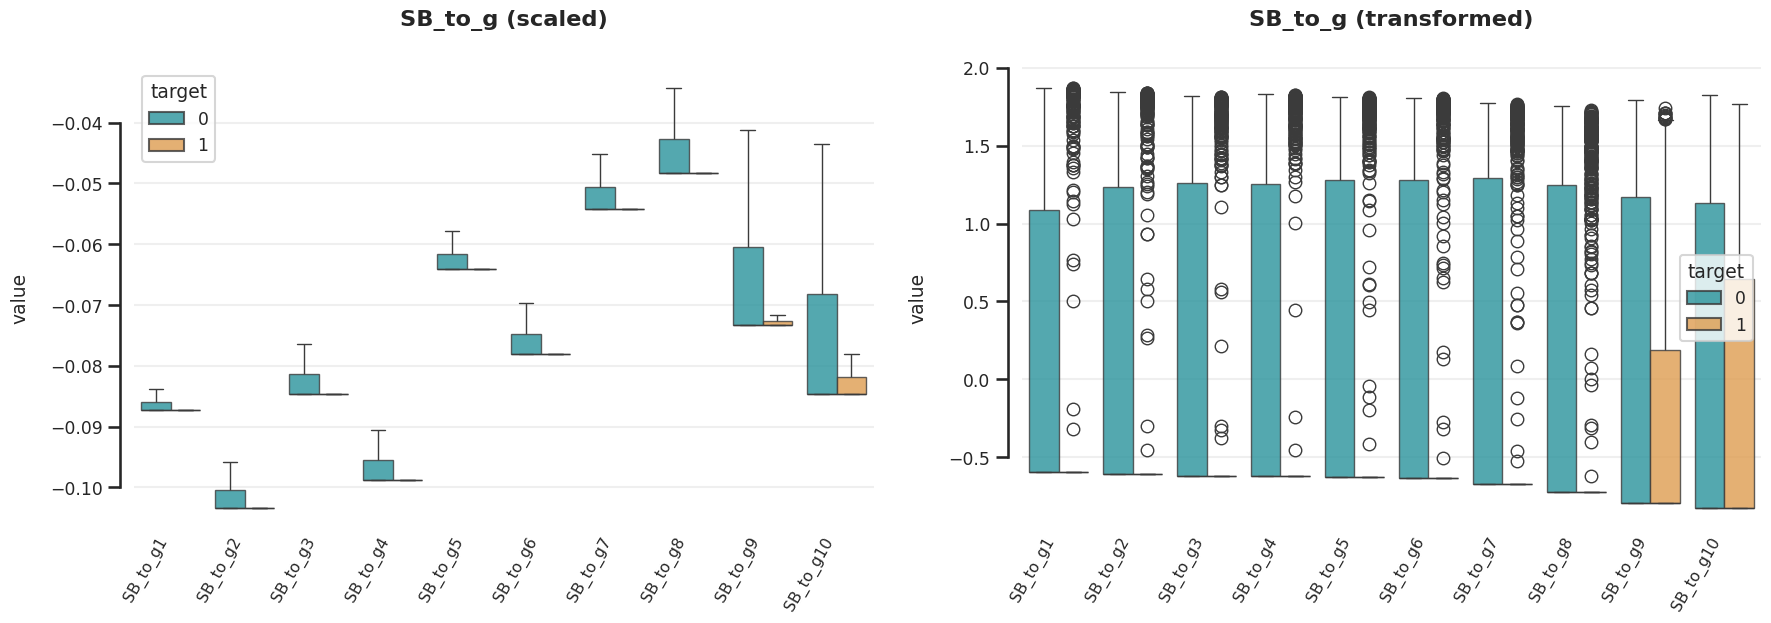

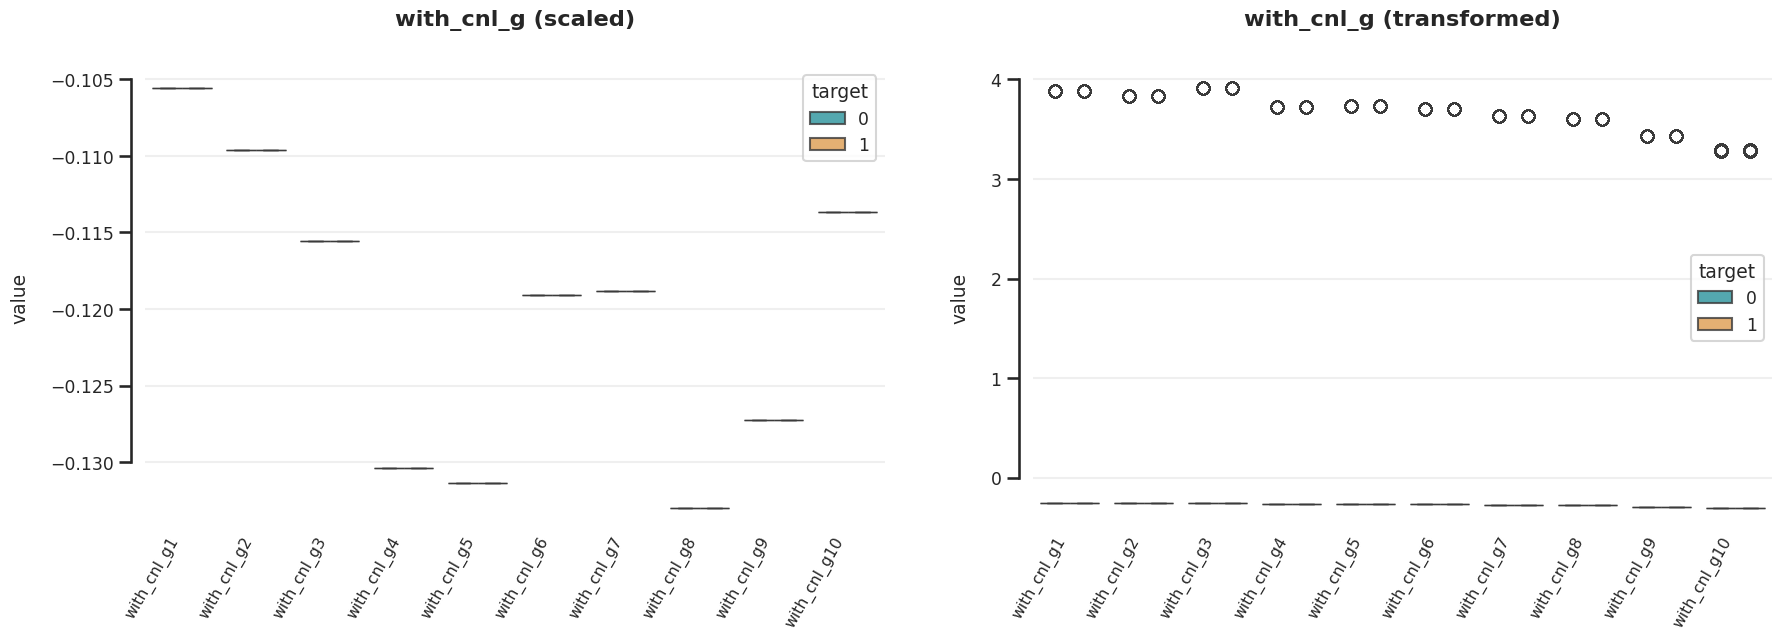

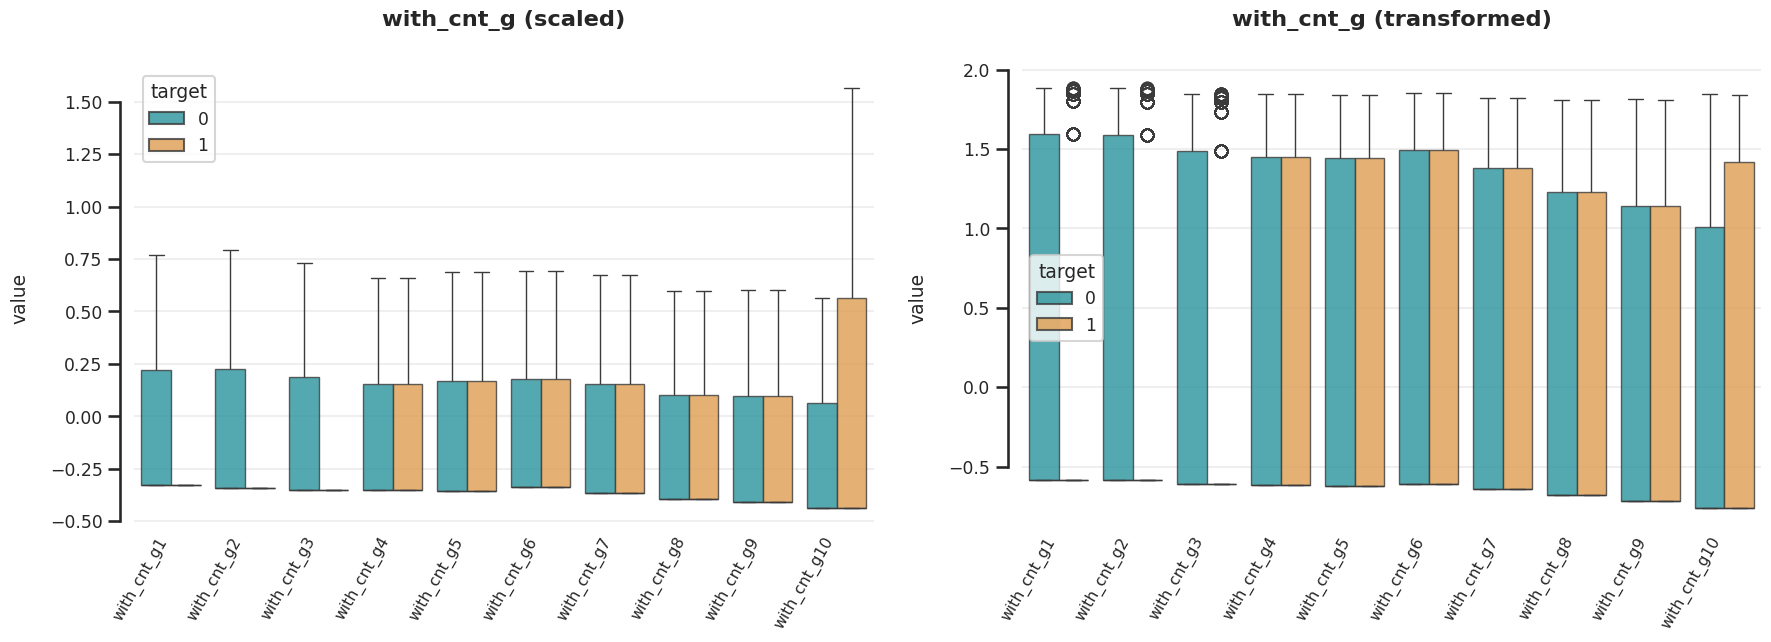

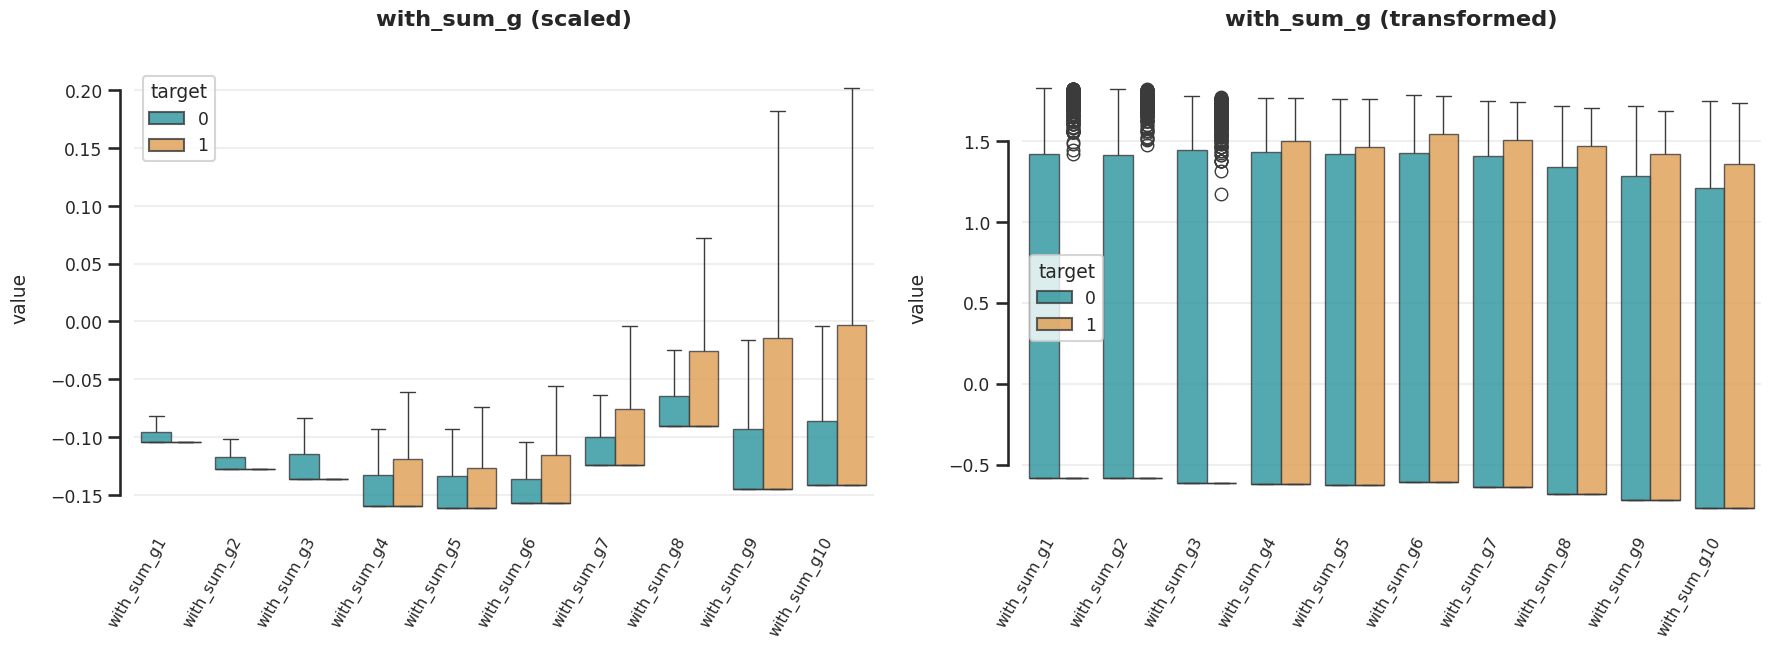

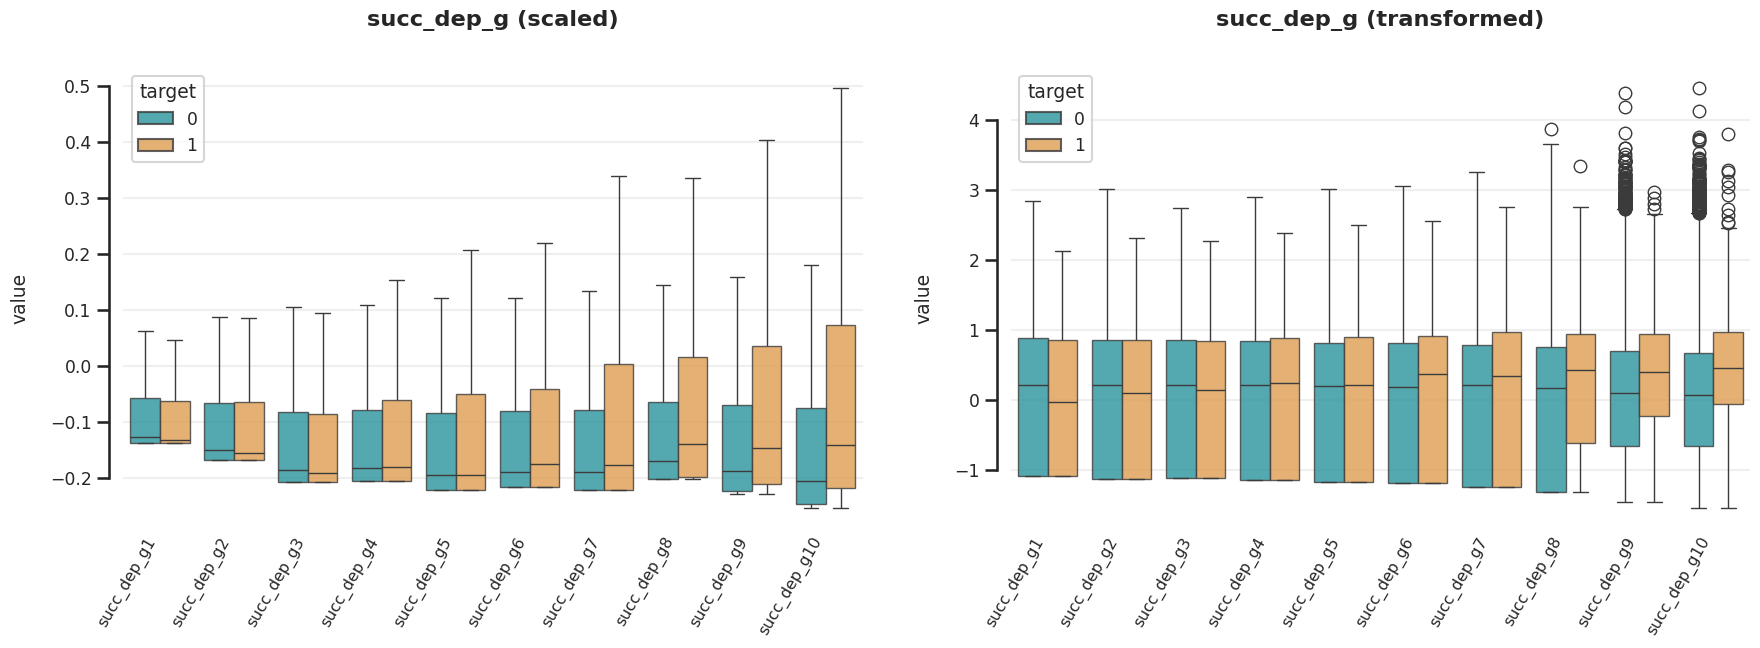

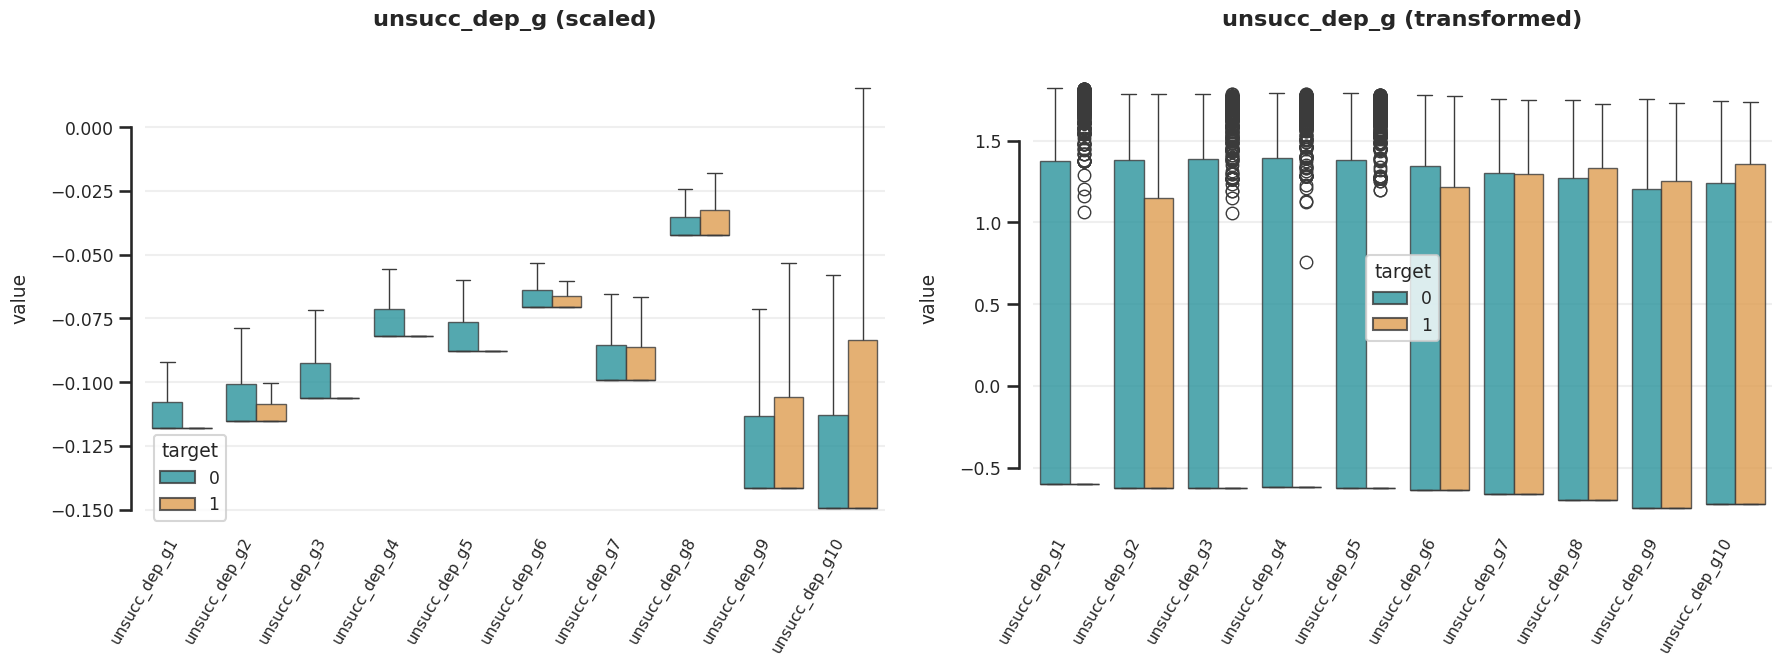

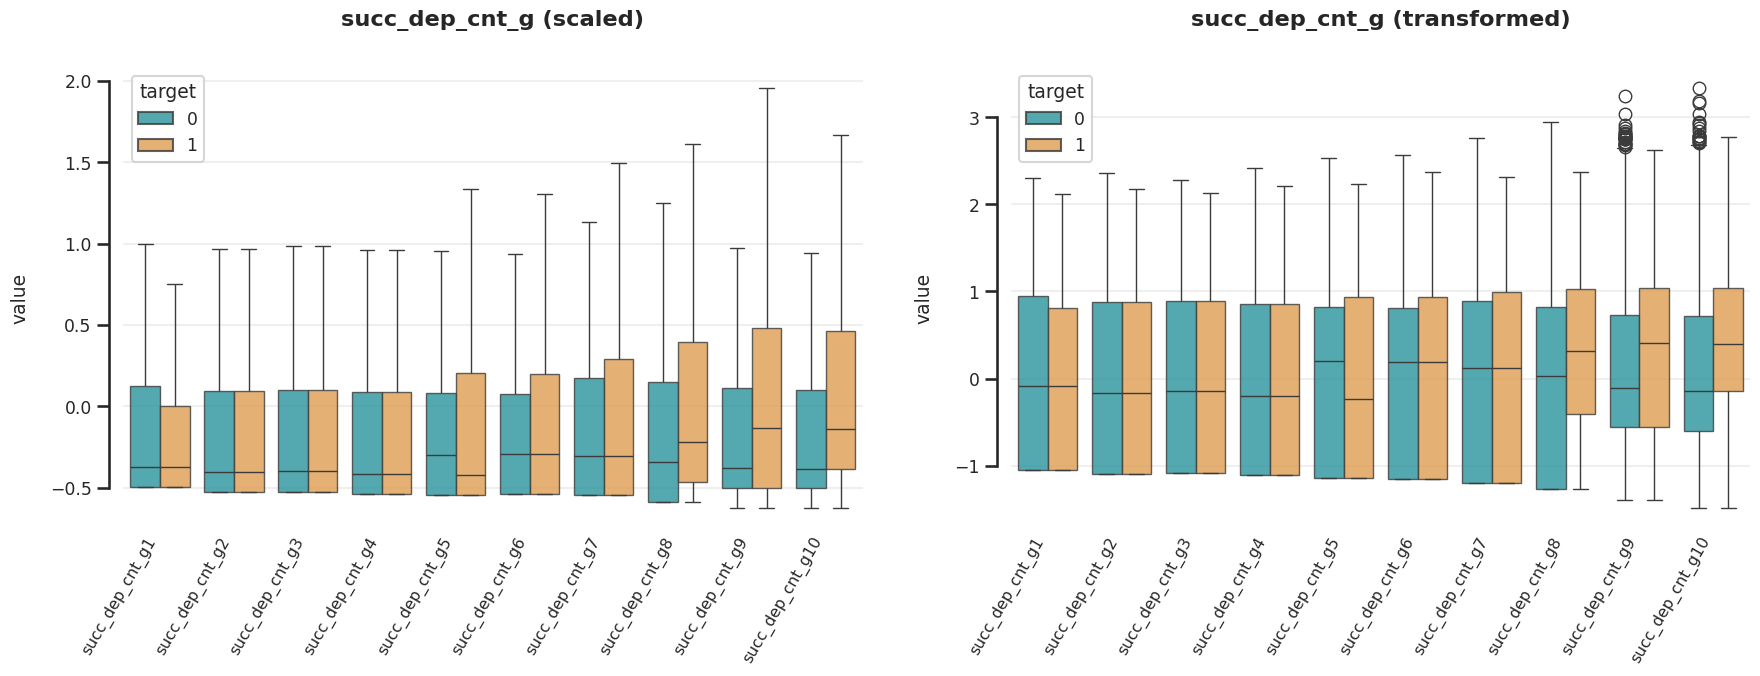

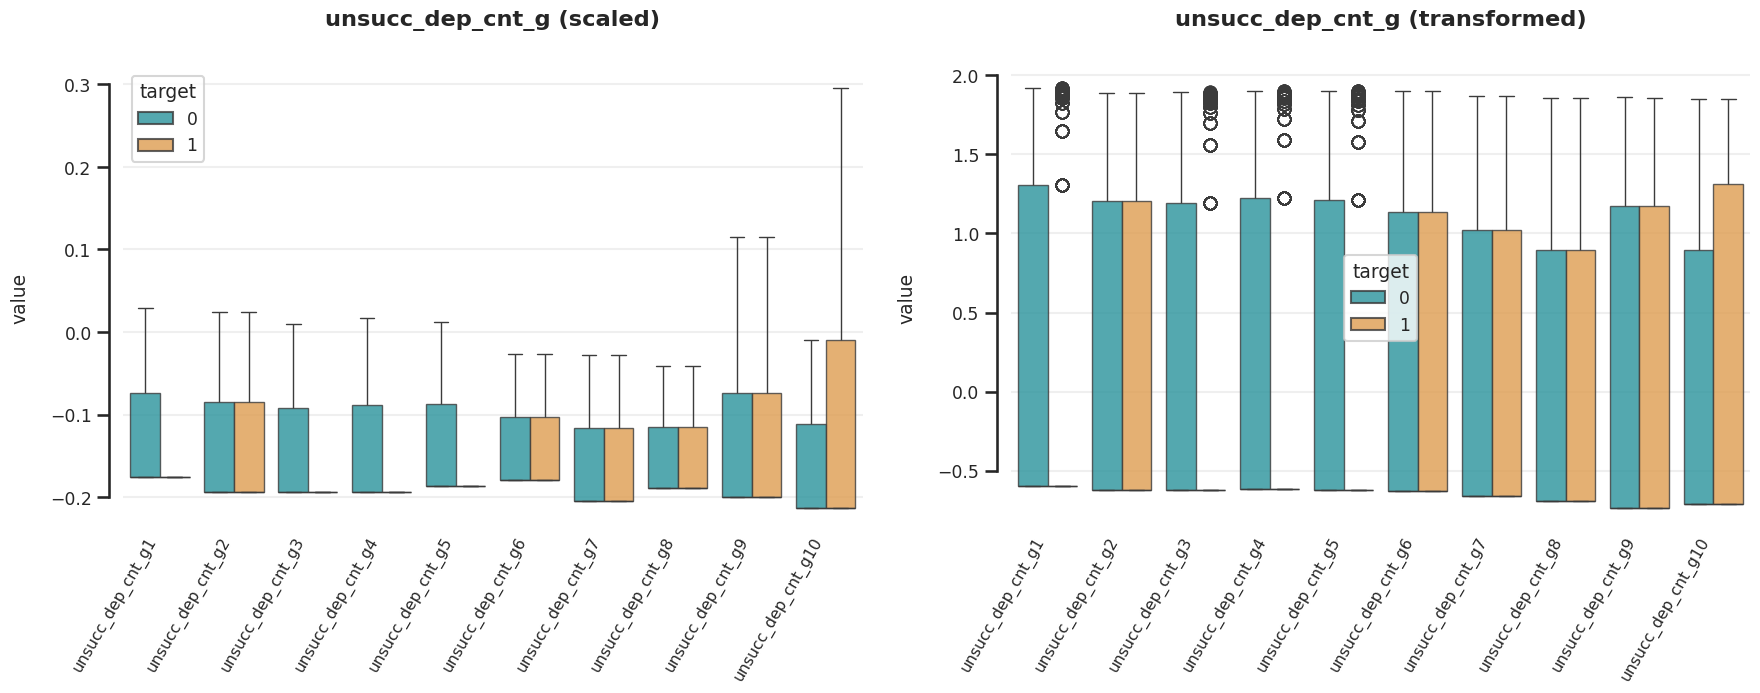

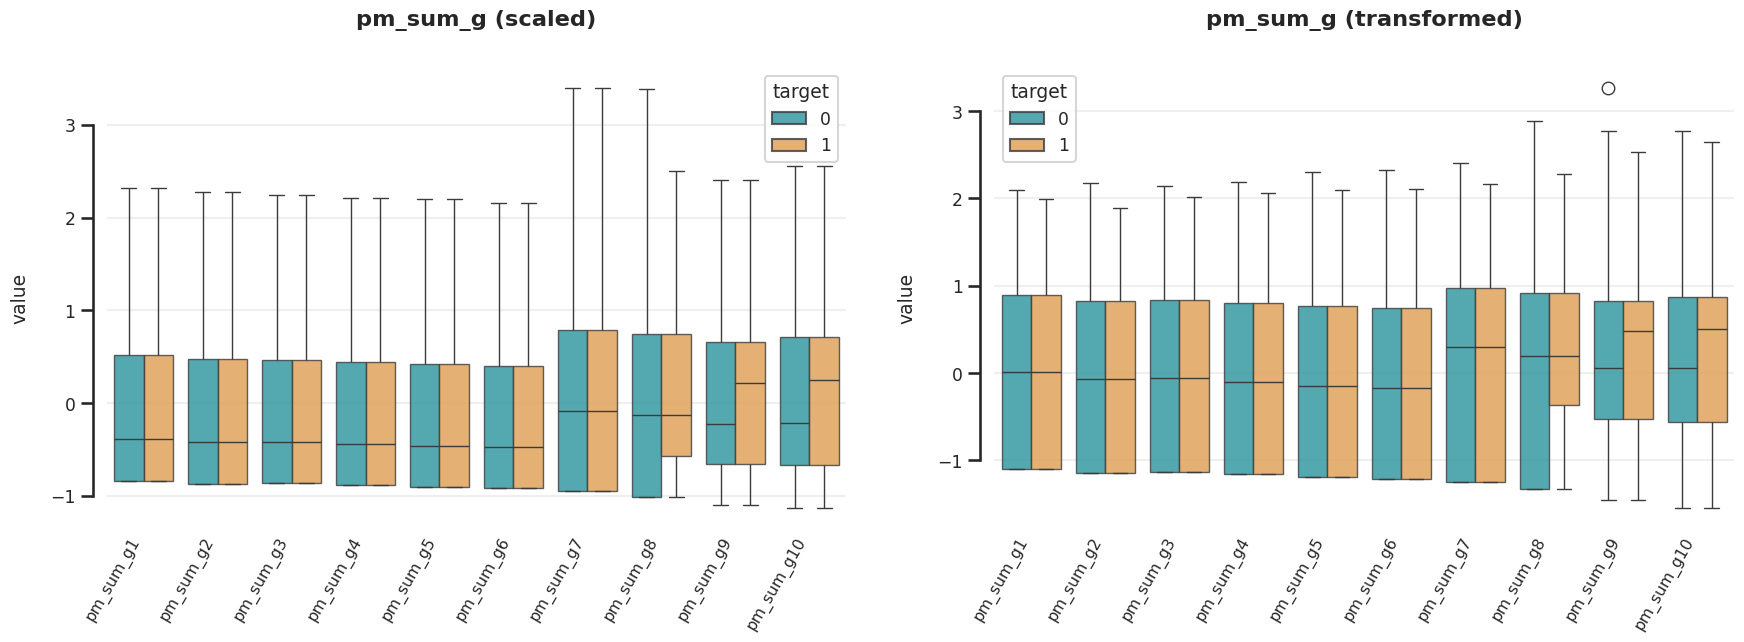

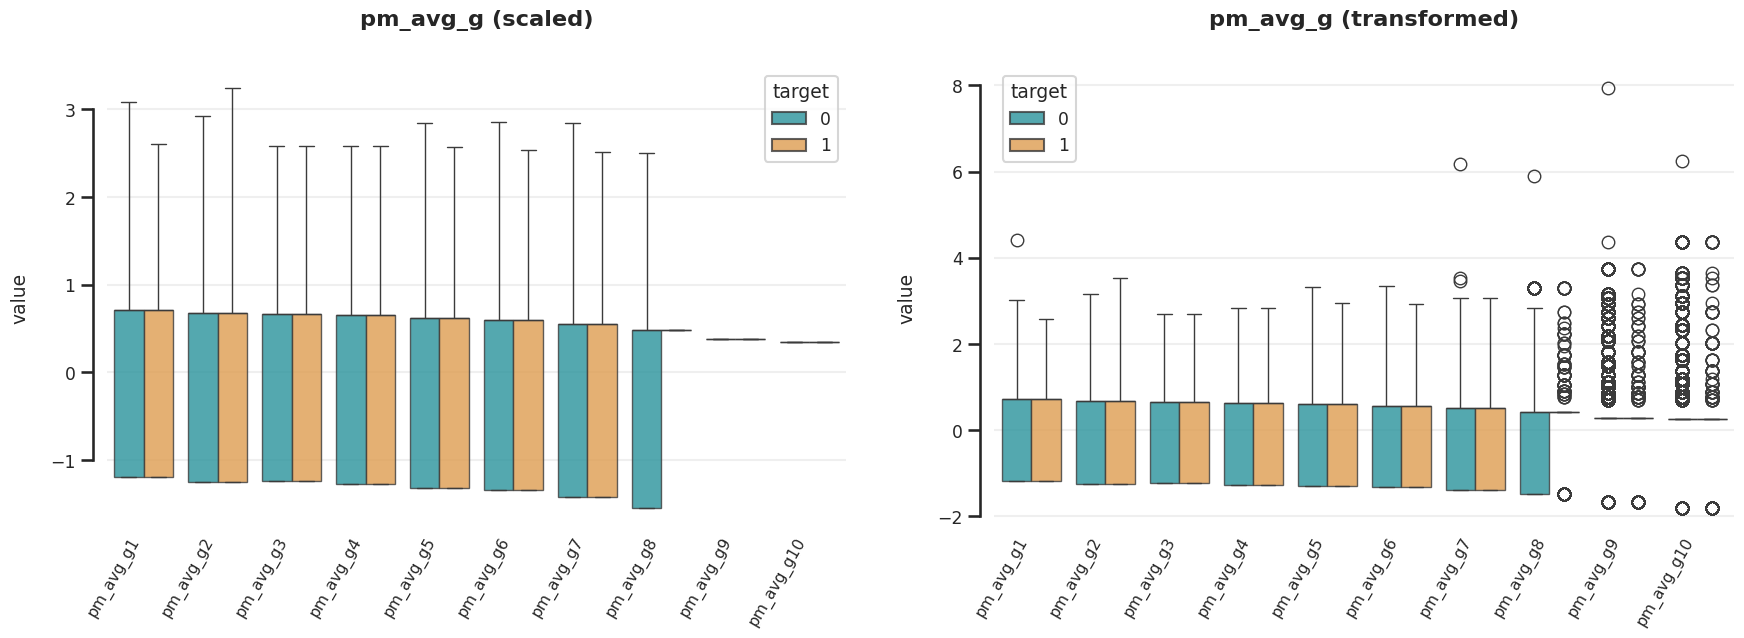

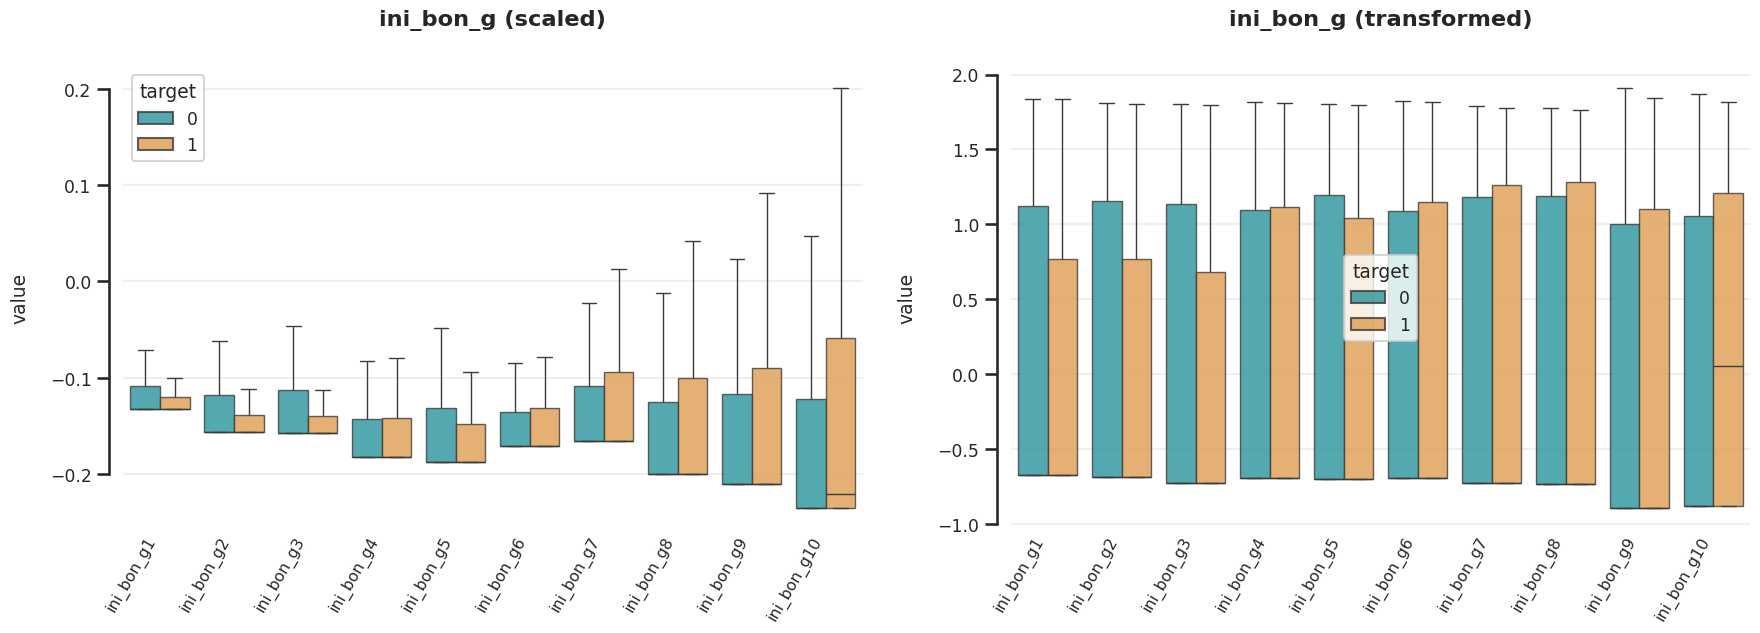

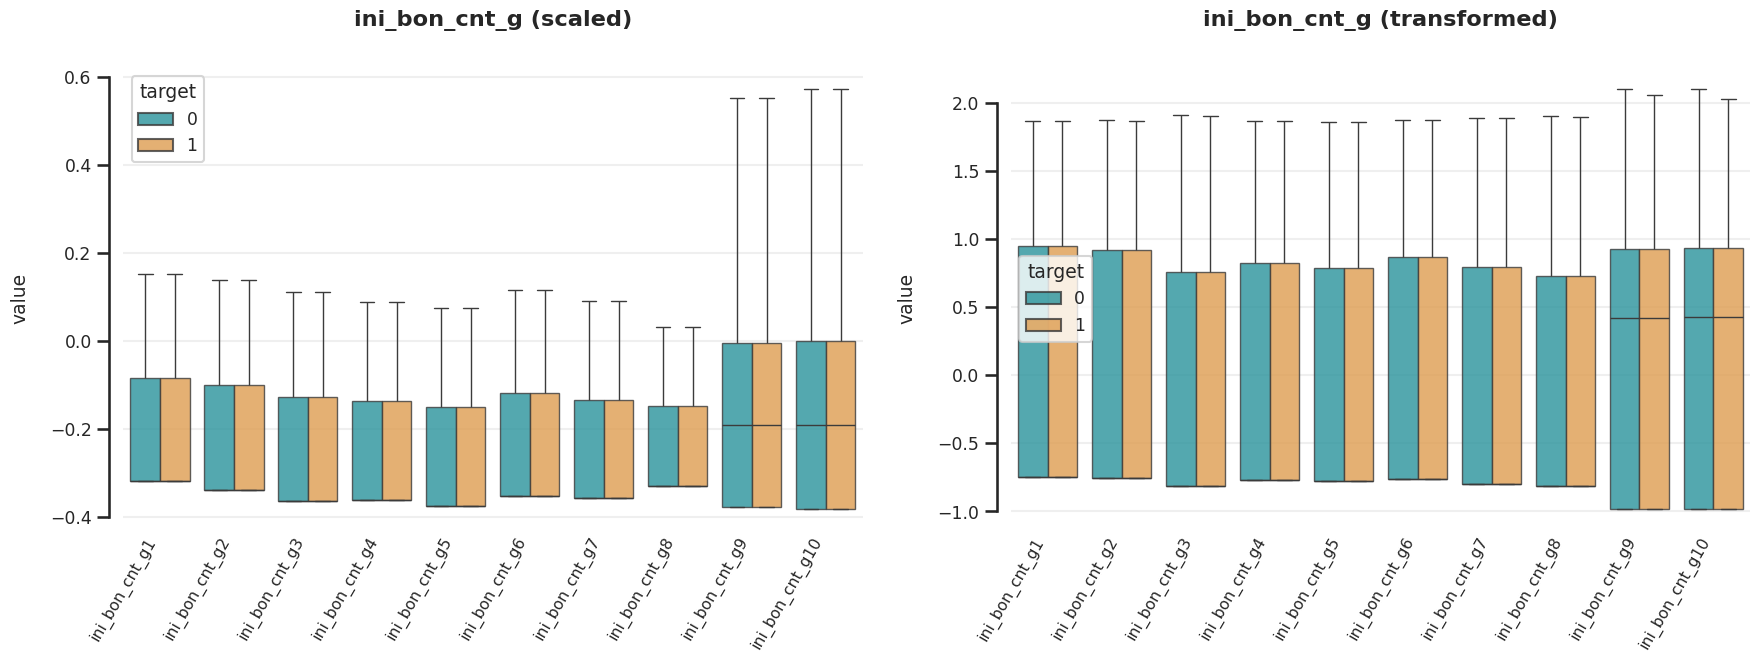

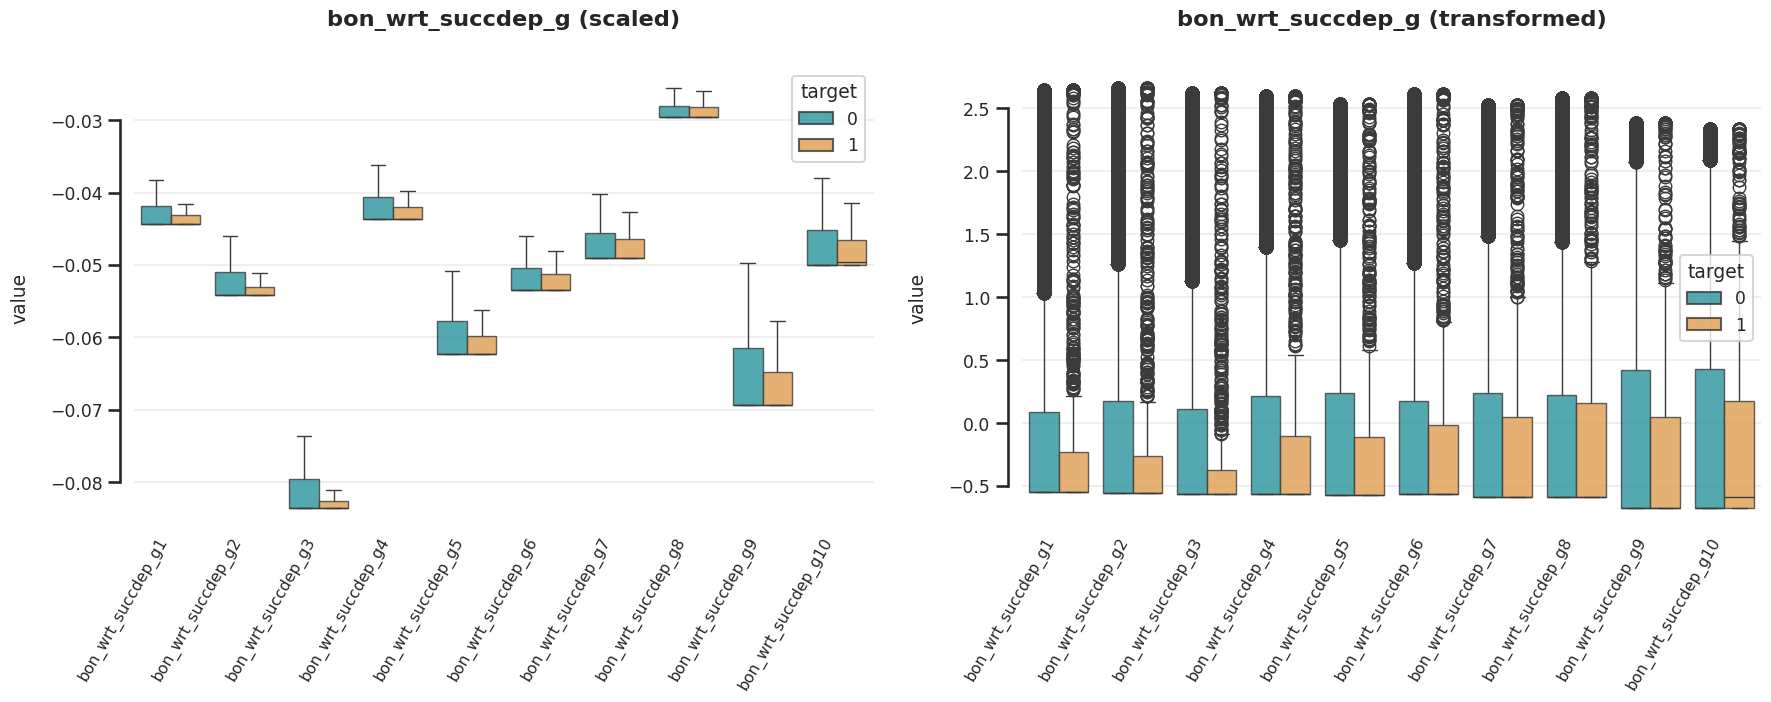

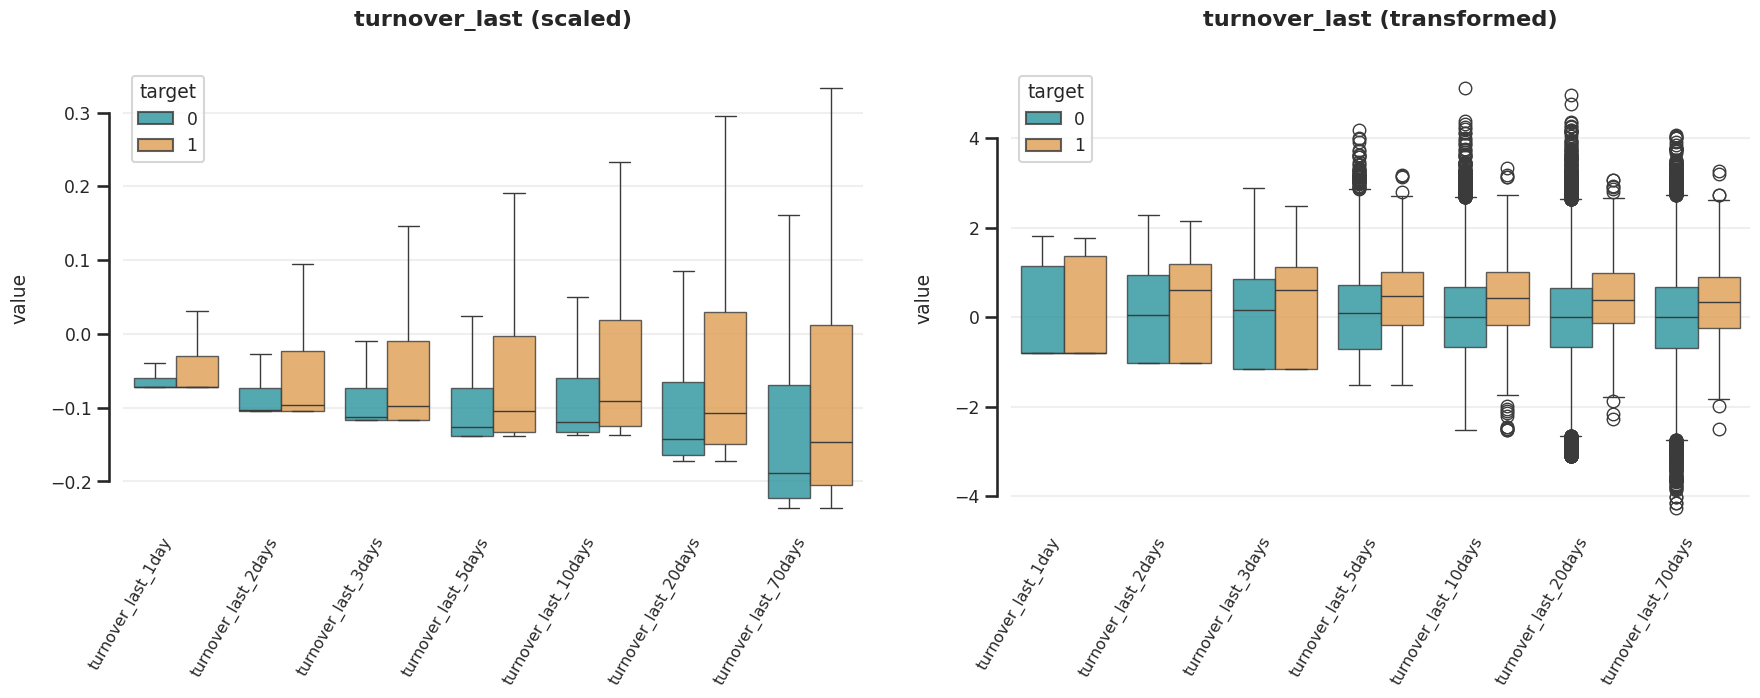

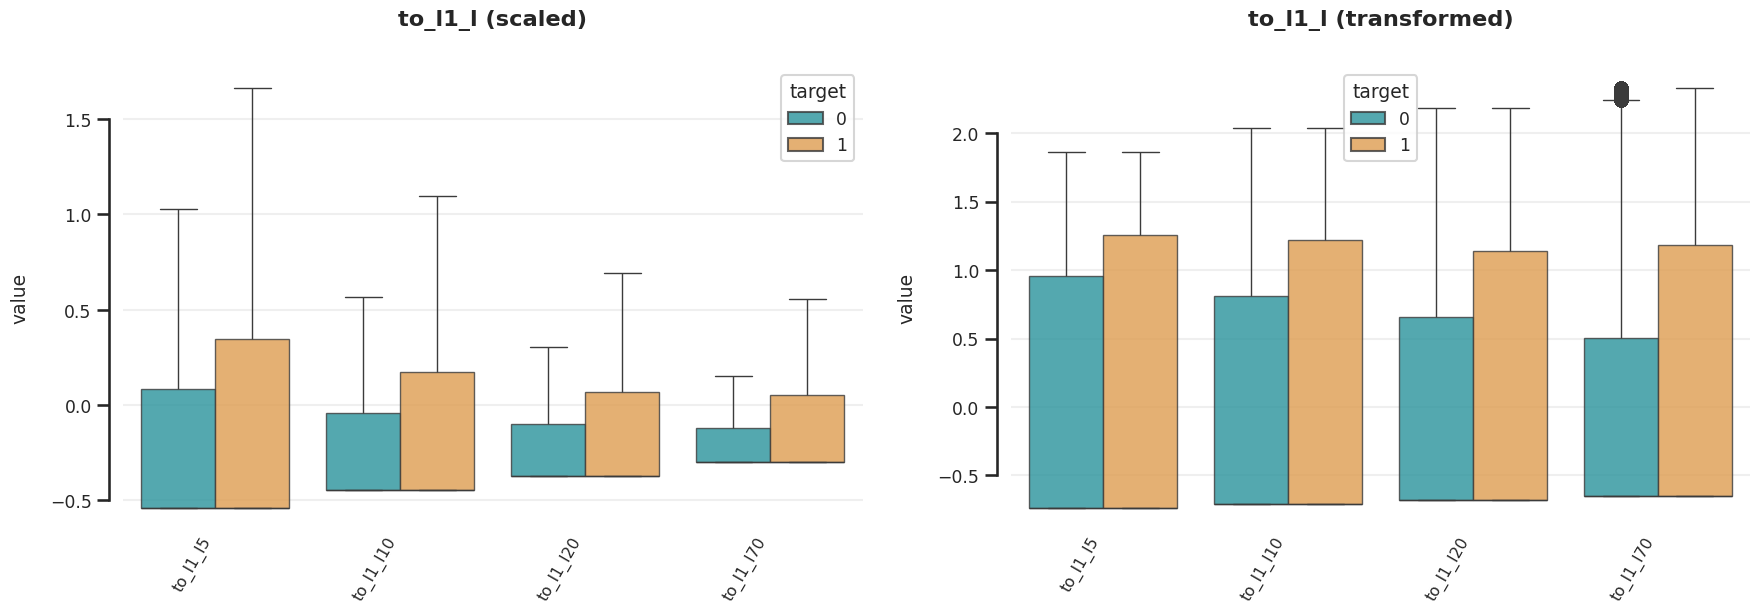

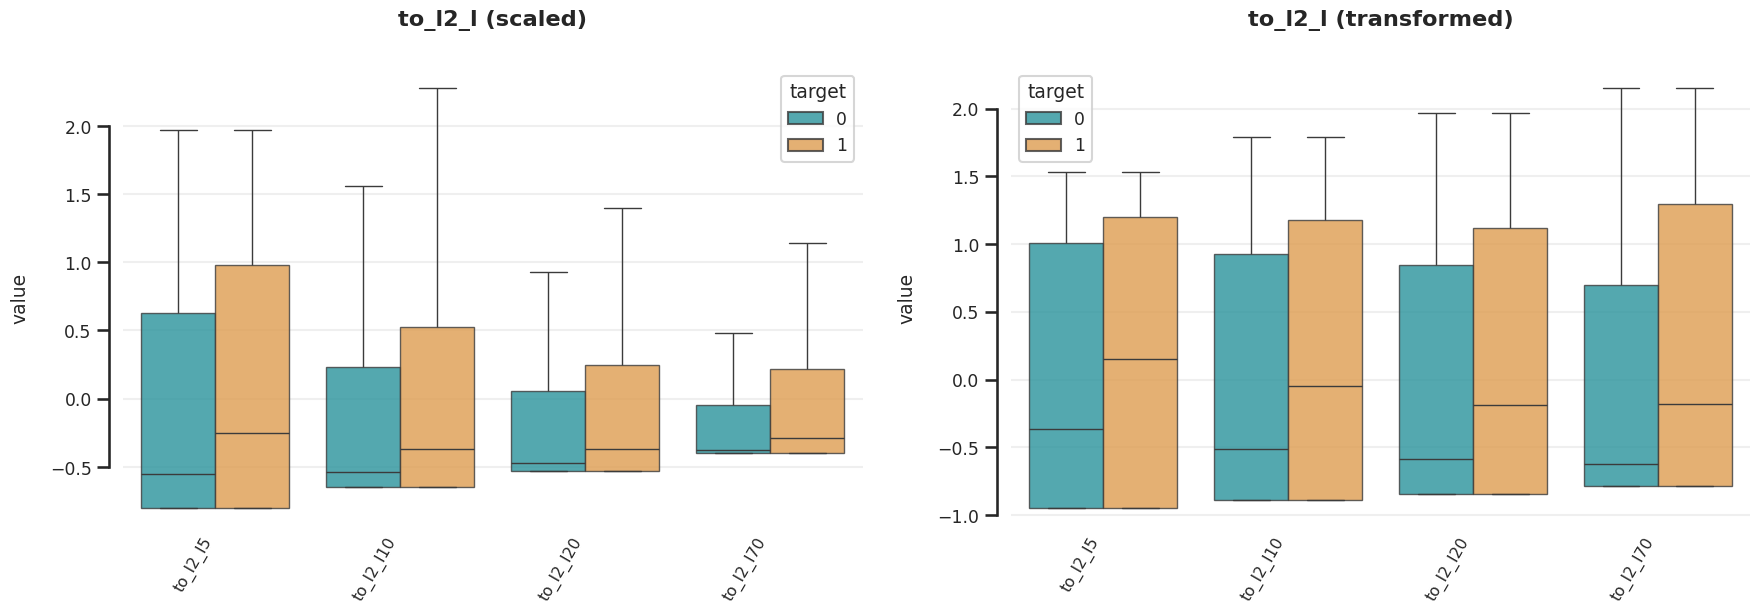

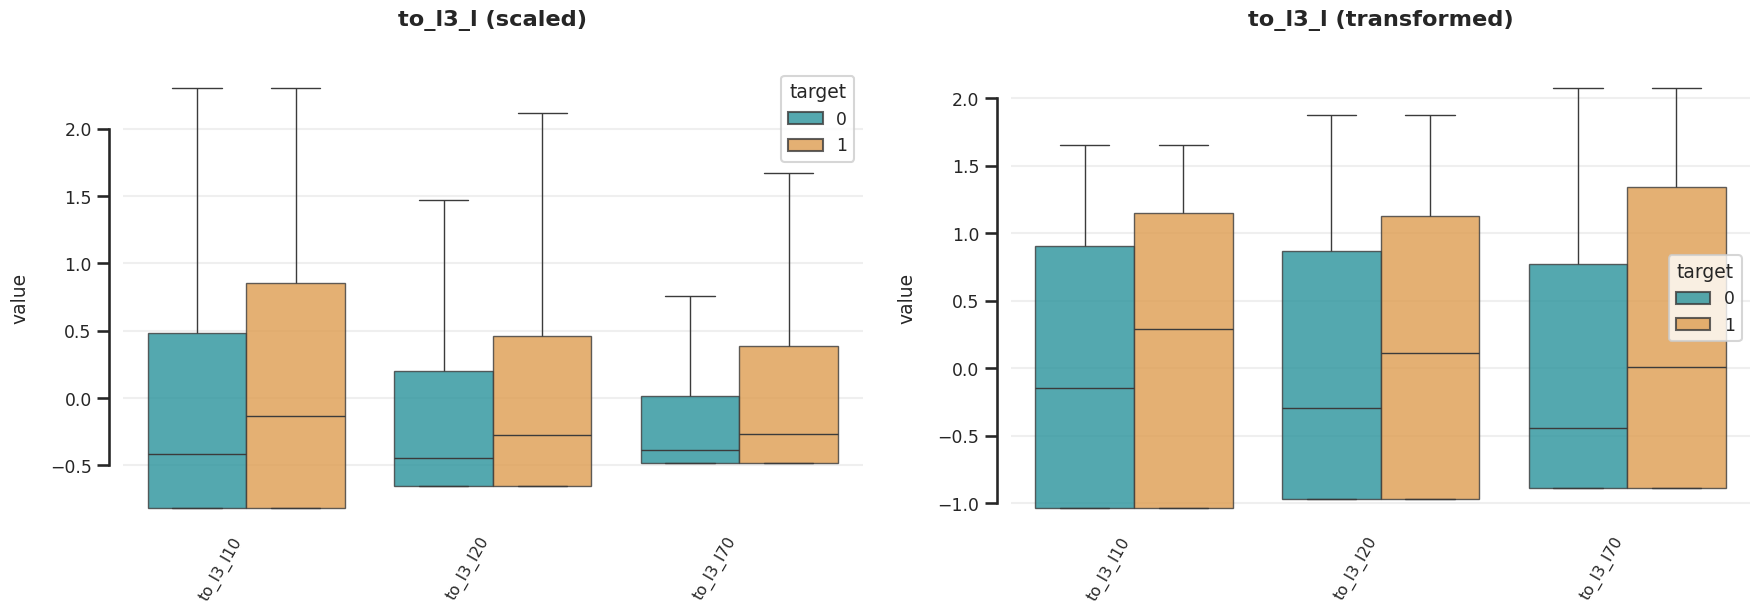

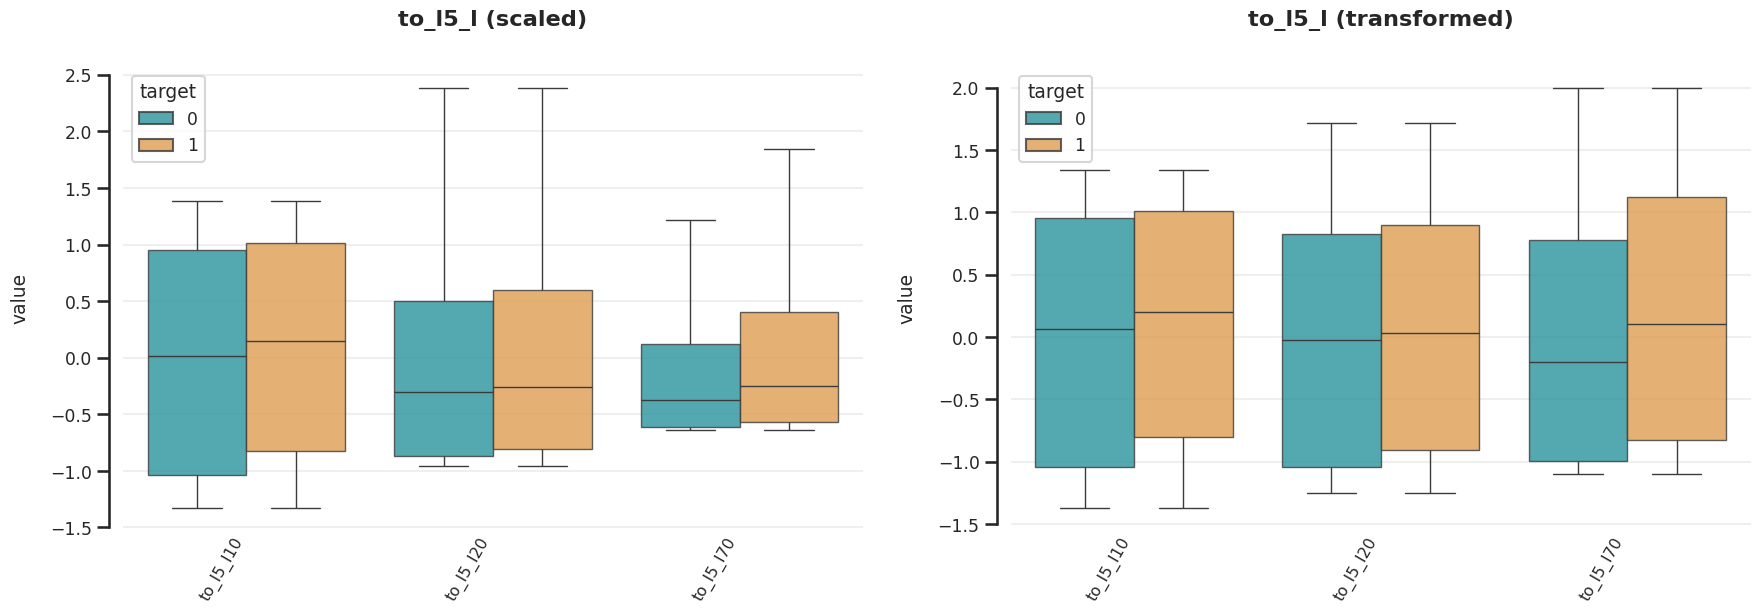

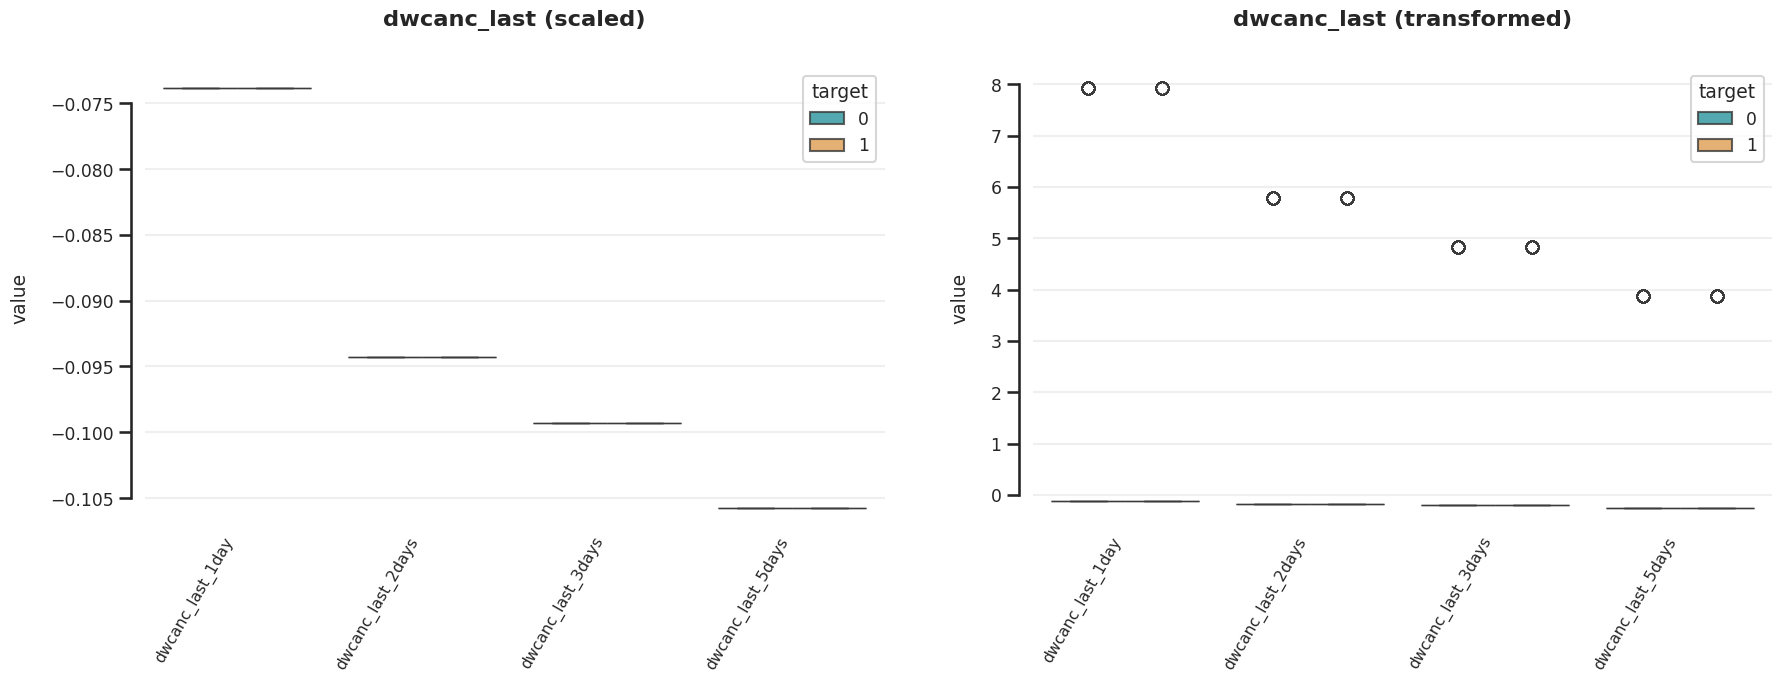

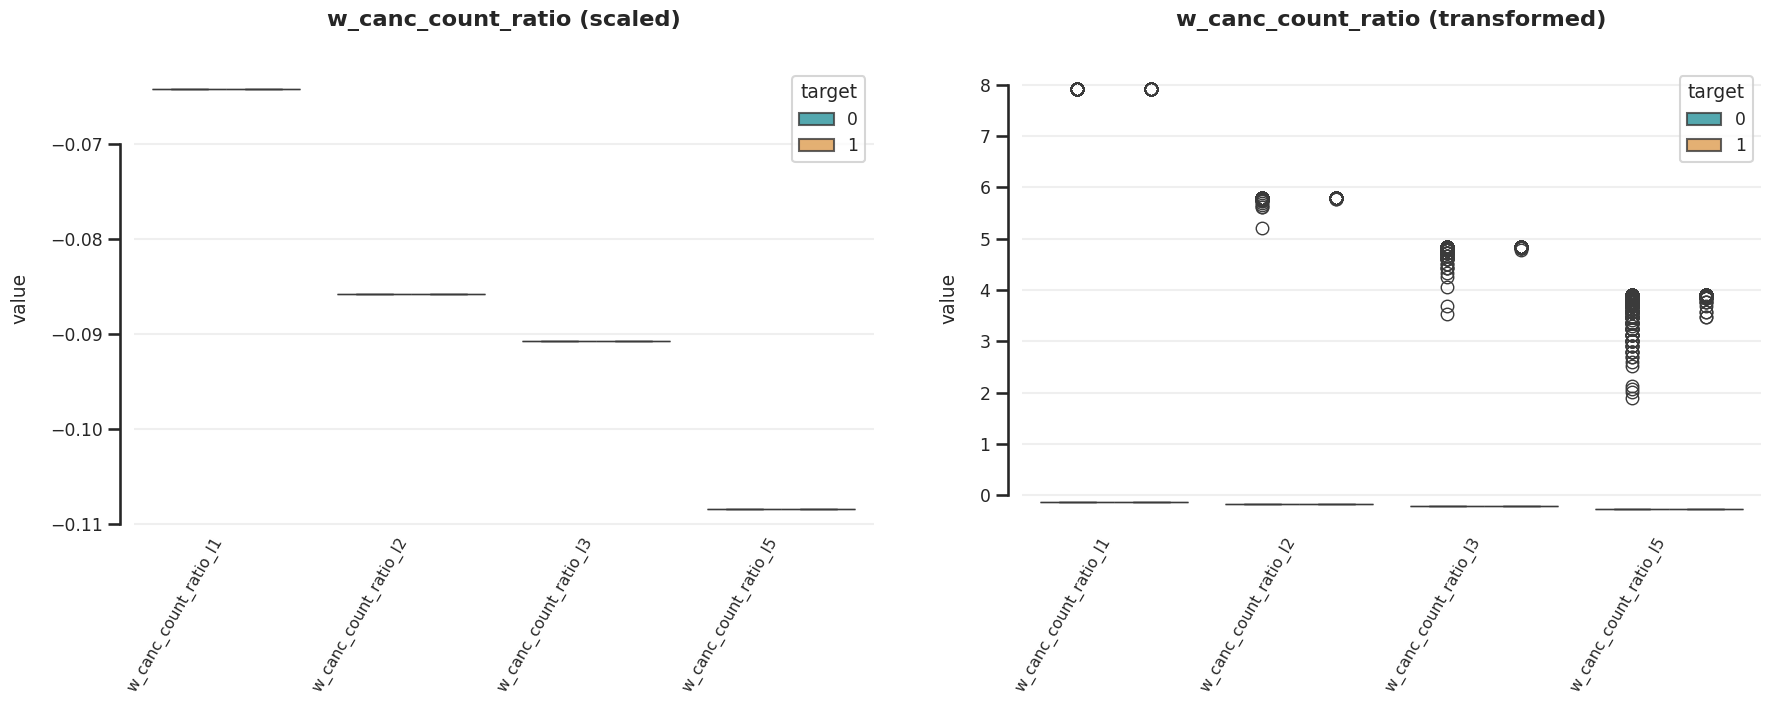

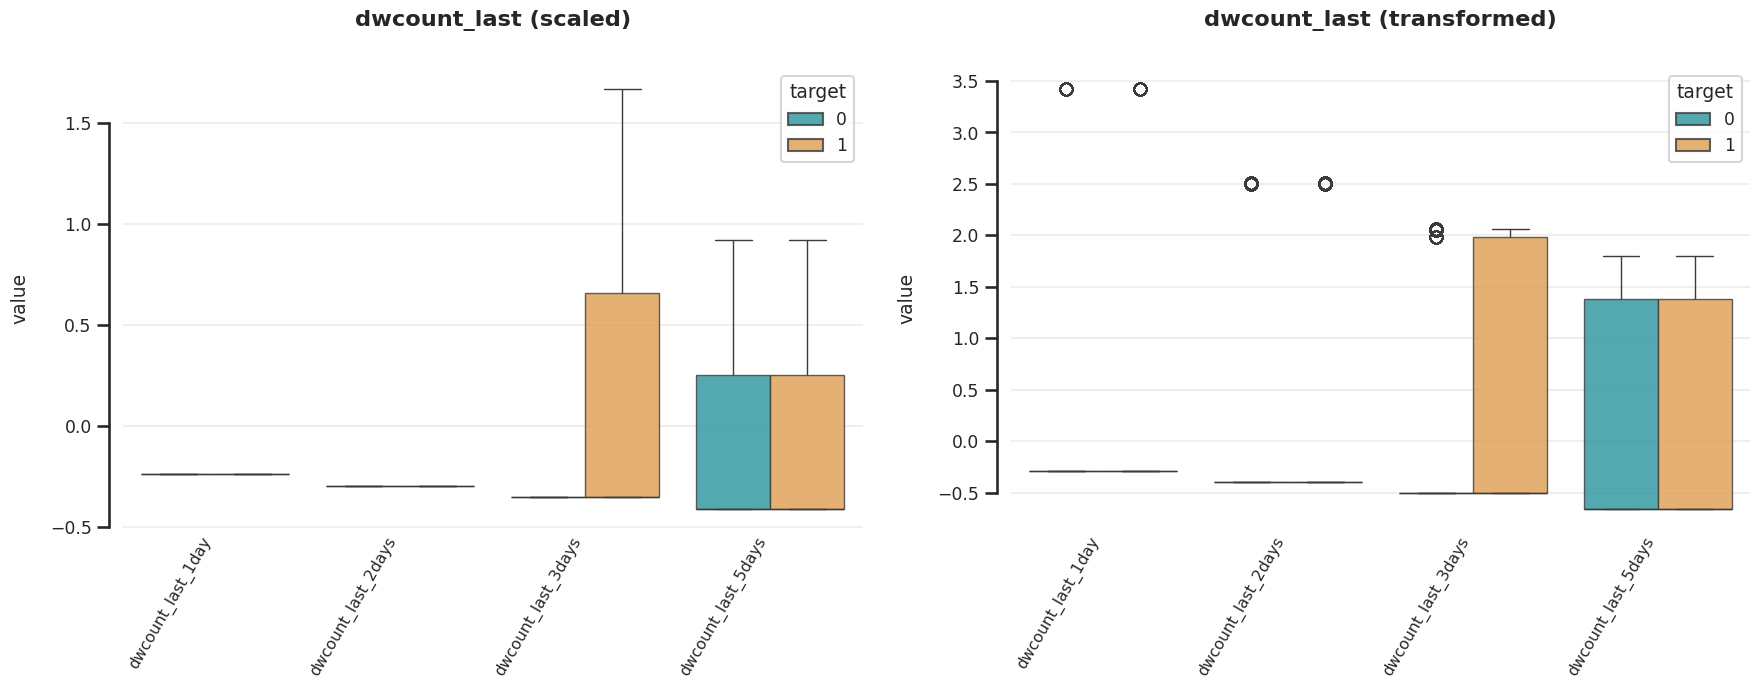

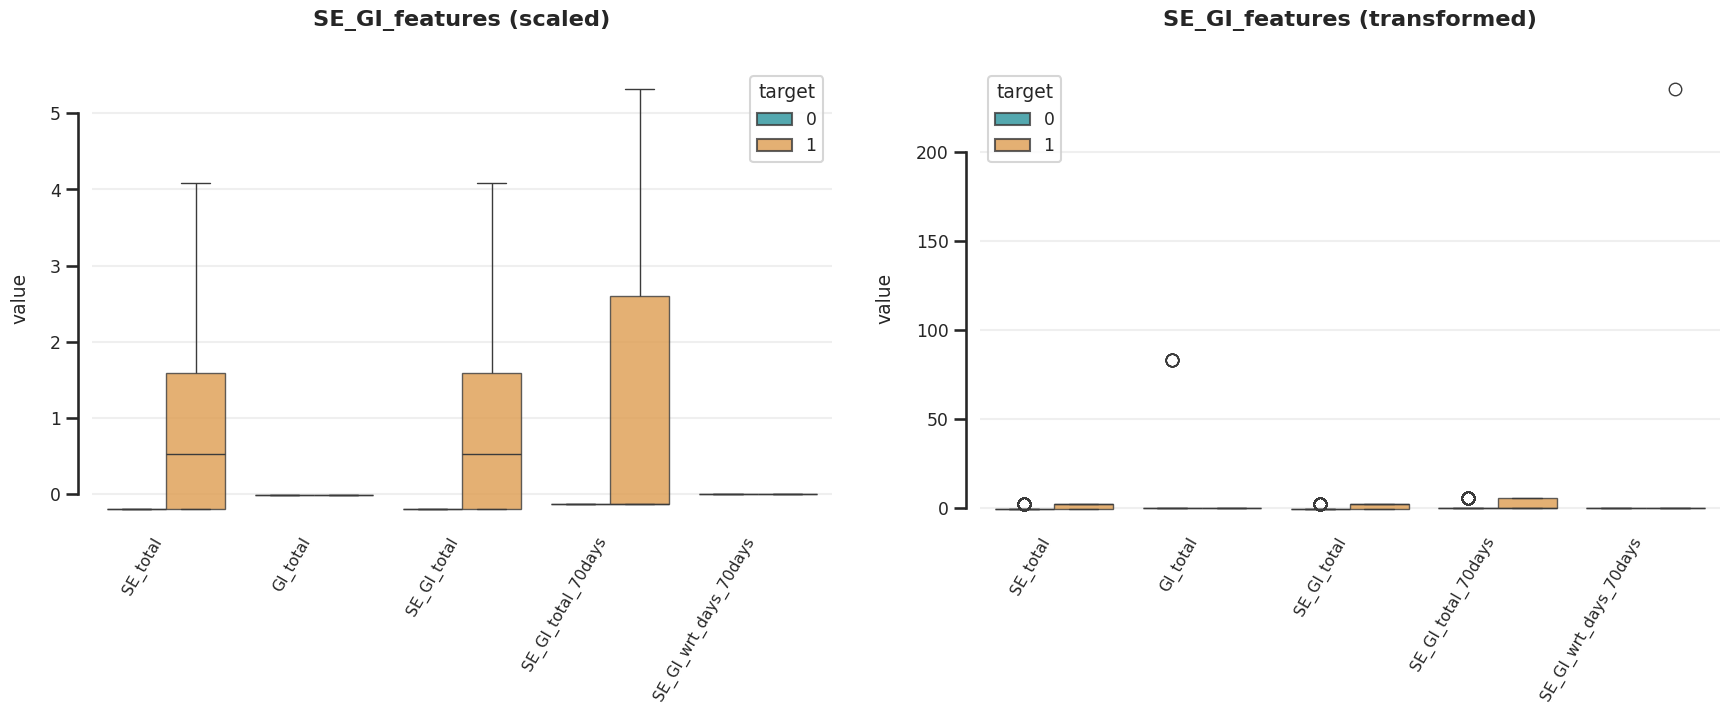

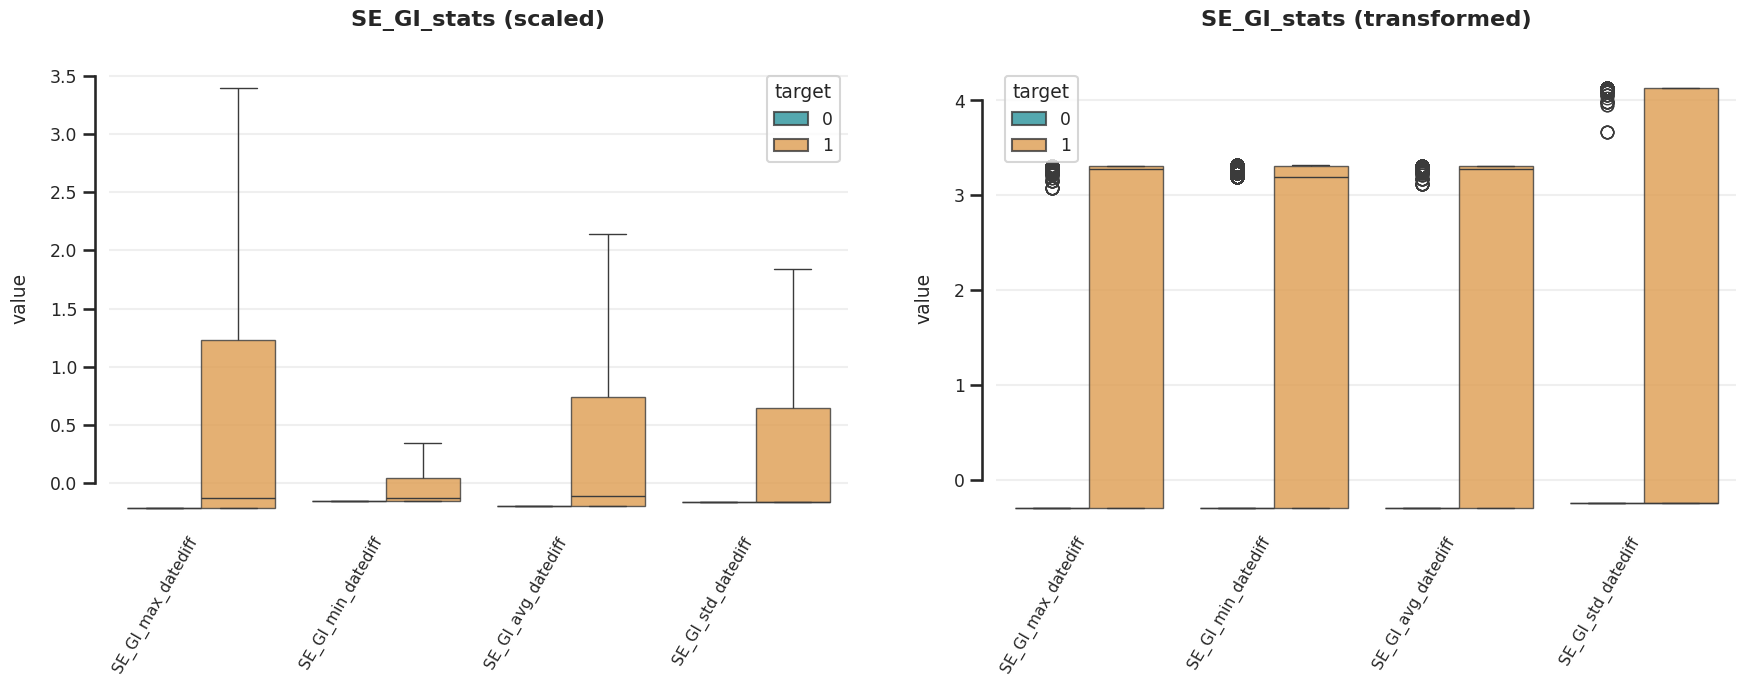

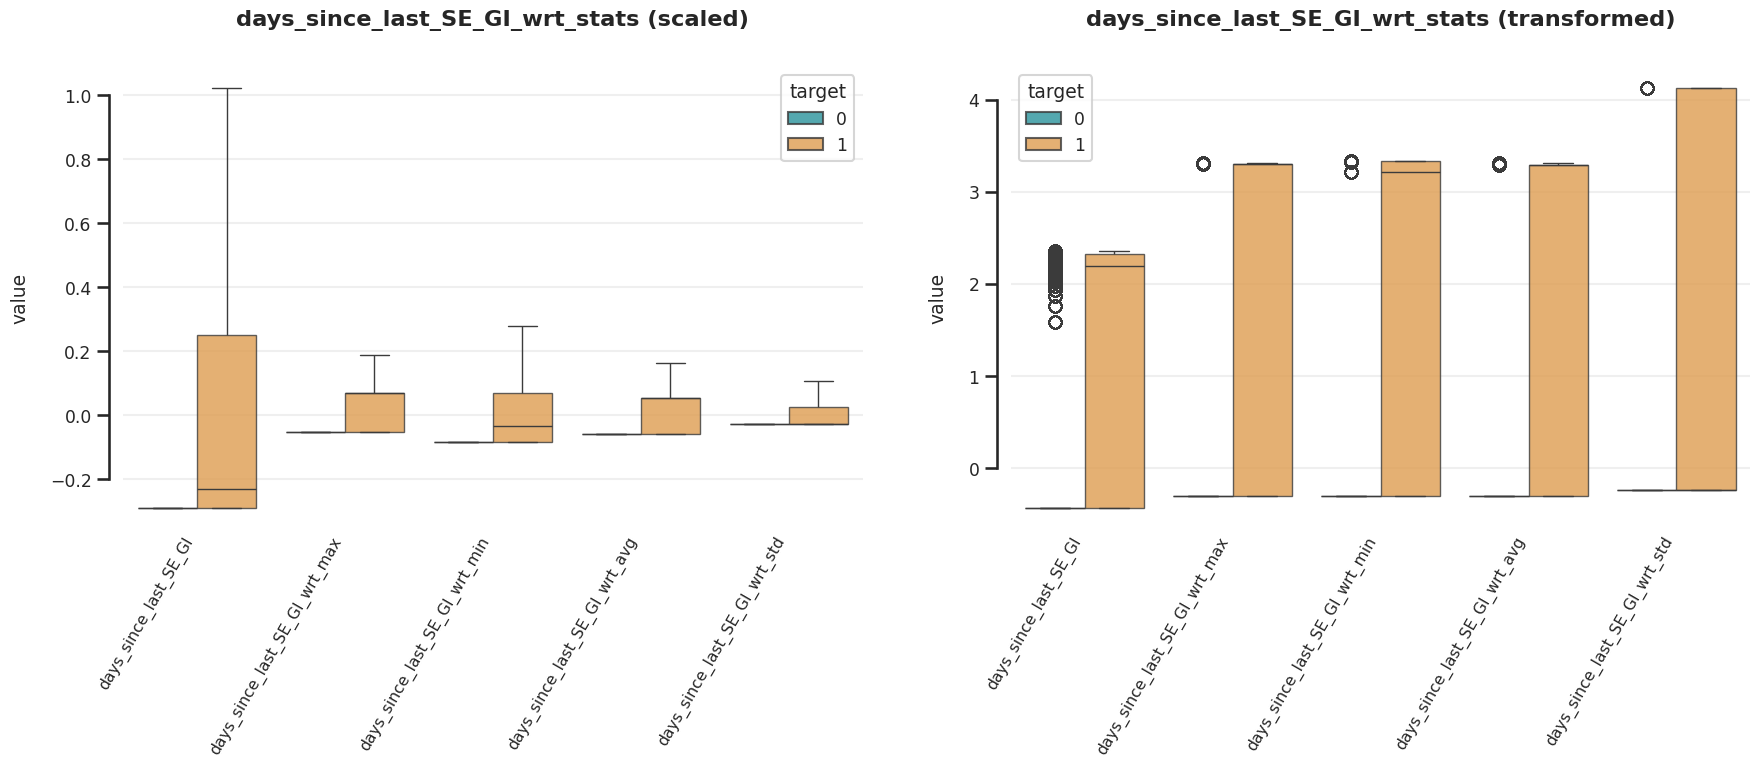

In [22]:
# Plot scaled (without outliers) and transformed (Yeo–Johnson, with outliers) distributions with boxplot
for feature_type in list(FEATURE_COLUMNS.keys()):

    feature_columns = FEATURE_COLUMNS[feature_type]

    df_feature_target = df[[*feature_columns,'target']].copy()
    df_feature_target_transformed = df_feature_target.copy()
    df_feature_target[feature_columns] = df_feature_target[feature_columns].apply(scale)
    df_feature_target_transformed[feature_columns] = power_transform(df_feature_target_transformed[feature_columns])

    df_feature_target = df_feature_target.melt(id_vars='target')
    df_feature_target_transformed = df_feature_target_transformed.melt(id_vars='target')

    fig,axes = plt.subplots(ncols=2, figsize=(21,6))
    sns.boxplot(data=df_feature_target, x='variable', y='value', hue='target', boxprops=dict(alpha=.8), showfliers=False, ax=axes[0])
    sns.boxplot(data=df_feature_target_transformed, x='variable', y='value', hue='target', boxprops=dict(alpha=.8), showfliers=True, ax=axes[1])

    for i,ax in enumerate(axes):

        sns.despine(trim=True, bottom=True, offset=10, ax=ax)
        ax.set_title(f'{feature_type} (transformed)' if i != 0 else f'{feature_type} (scaled)')
        
        ax.set_xlabel(None)
        ax.tick_params(axis='x', length=0, rotation=60, labelsize='small')
        for label in ax.get_xticklabels():
            label.set_horizontalalignment('right')

    plt.show()
    print()

**Conclusion:**
- There are many with the same overall distribution pattern despite calling customer service (visual analysis).
- Some features like "days_since_last_SE_GI", "SE_GI_max_datediff", and others show distinct distribution patterns

Example of a particular important feature:

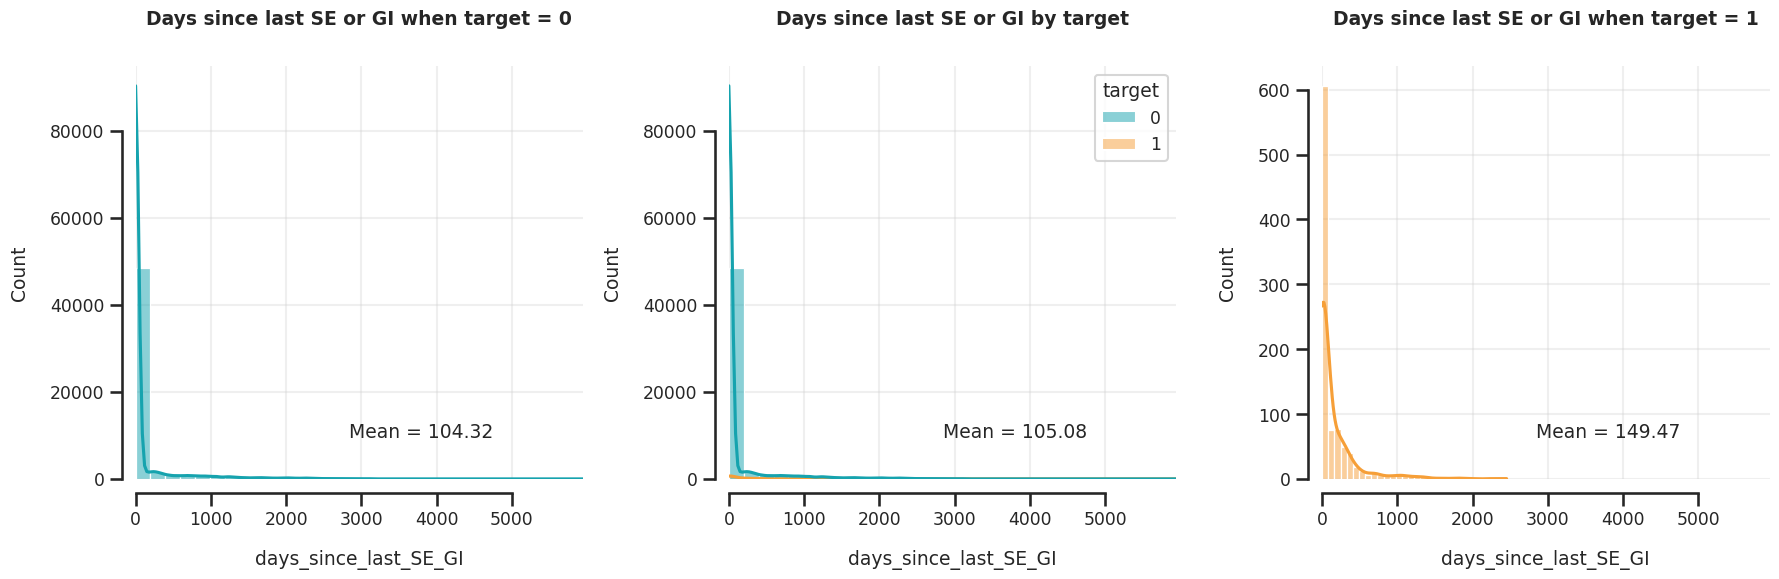

In [23]:
df_days_since_last_SE_GI = df[['days_since_last_SE_GI','target']]
df_days_since_last_SE_GI_0 = df.query('target==0')['days_since_last_SE_GI']
df_days_since_last_SE_GI_1 = df.query('target==1')['days_since_last_SE_GI']

titles = [
    'Days since last SE or GI when target = 0',
    'Days since last SE or GI by target',
    'Days since last SE or GI when target = 1'
]

averages = [
    df_days_since_last_SE_GI_0.mean(),
    df_days_since_last_SE_GI.days_since_last_SE_GI.mean(),
    df_days_since_last_SE_GI_1.mean()
]


xmin, xmax = df.days_since_last_SE_GI.agg(['min','max'])

fig,axes = plt.subplots(ncols=3, figsize=(18,6))

sns.histplot(df_days_since_last_SE_GI_0, kde=True, ax=axes[0], color='#16a3ae', bins=30)
sns.histplot(data=df_days_since_last_SE_GI, x='days_since_last_SE_GI', hue='target', kde=True, ax=axes[1], bins=30)
sns.histplot(df_days_since_last_SE_GI_1, kde=True, ax=axes[2], color='#f69f38', bins=30)

for ax,avg,title in zip(axes, averages, titles):
    ax.set_title(title, size='medium')
    ax.set(xlim=[xmin,xmax])
    ax.annotate(f'Mean = {avg:.2f}', (.8, .1), xycoords='axes fraction', ha='right')
    sns.despine(trim=True, offset=10, ax=ax)

plt.tight_layout()
plt.show()

When plotted together, the difference is hard to see because the target proportions are highly imbalanced (center). We can notice the difference when plotting them separately. Within the group of customers who called customer service (target=1), the density decreased smoothly and slower for more days since the last gambling issue or self-exclusion (right panel) than in the group who didn't call (left panel).

#### Statistical analysis

##### Mann–Whitney U test

The Mann-Whitney U test is a nonparametric test of the null hypothesis that the distribution underlying sample x is the same as the distribution underlying sample y. It is often used as a test of difference in location between distributions.

In [24]:
# Applying the test to the two distinct target groups for each feature
mannwhitneyu_results = []

for feature in df_num.columns:
    a = df.query('target==0')[feature]
    b = df.query('target==1')[feature]
    statistic, pvalue = stats.mannwhitneyu(a, b)
    mannwhitneyu_results.append({
        'feature': feature,
        'statistic': statistic,
        'pvalue': pvalue
        })

In [25]:
# Showing the results with pandas style
df_mannwhitneyu_results = (
    pd.DataFrame(mannwhitneyu_results)
    .query('pvalue<0.05')
    .set_index('feature')
    .sort_values('pvalue')
    .style
    .format('{:.4f}', subset=['pvalue'])
    .background_gradient(cmap='Oranges')
)

df_mannwhitneyu_results

,statistic,pvalue
feature,,
days_since_last_SE_GI_wrt_std,16897754.500000,0.0000
days_since_last_SE_GI_wrt_min,14638132.500000,0.0000
days_since_last_SE_GI_wrt_max,14771908.500000,0.0000
SE_total,11191893.500000,0.0000
SE_GI_total,11193181.500000,0.0000
SE_GI_total_70days,18192066.000000,0.0000
days_since_last_SE_GI_wrt_avg,14785457.000000,0.0000
days_since_last_SE_GI,13422139.000000,0.0000
SE_GI_max_datediff,14683062.000000,0.0000


In [26]:
# Number of statistically significant features (the distributrion differs between the target groups)
(
    pd.DataFrame(mannwhitneyu_results)
    .assign(significant = lambda x: x.pvalue.lt(0.05))
    .significant
    .value_counts()
)

significant
True     198
False     69
Name: count, dtype: int64

Conclusion:
- 69 features don't have statistical distribution differences between target groups (p-value <0.05).
- The statistical difference from each feature doesn't necessarily mean it's important (the difference, despite statistically significant, might be slight).
- Distinct features may have the same overall information about the target (multicollinearity). We'll see that in the following cells.
- Furthermore, I've not applied a p-value correction approach like Bonferroni or FDR (false discovery rate).

##### Correlation

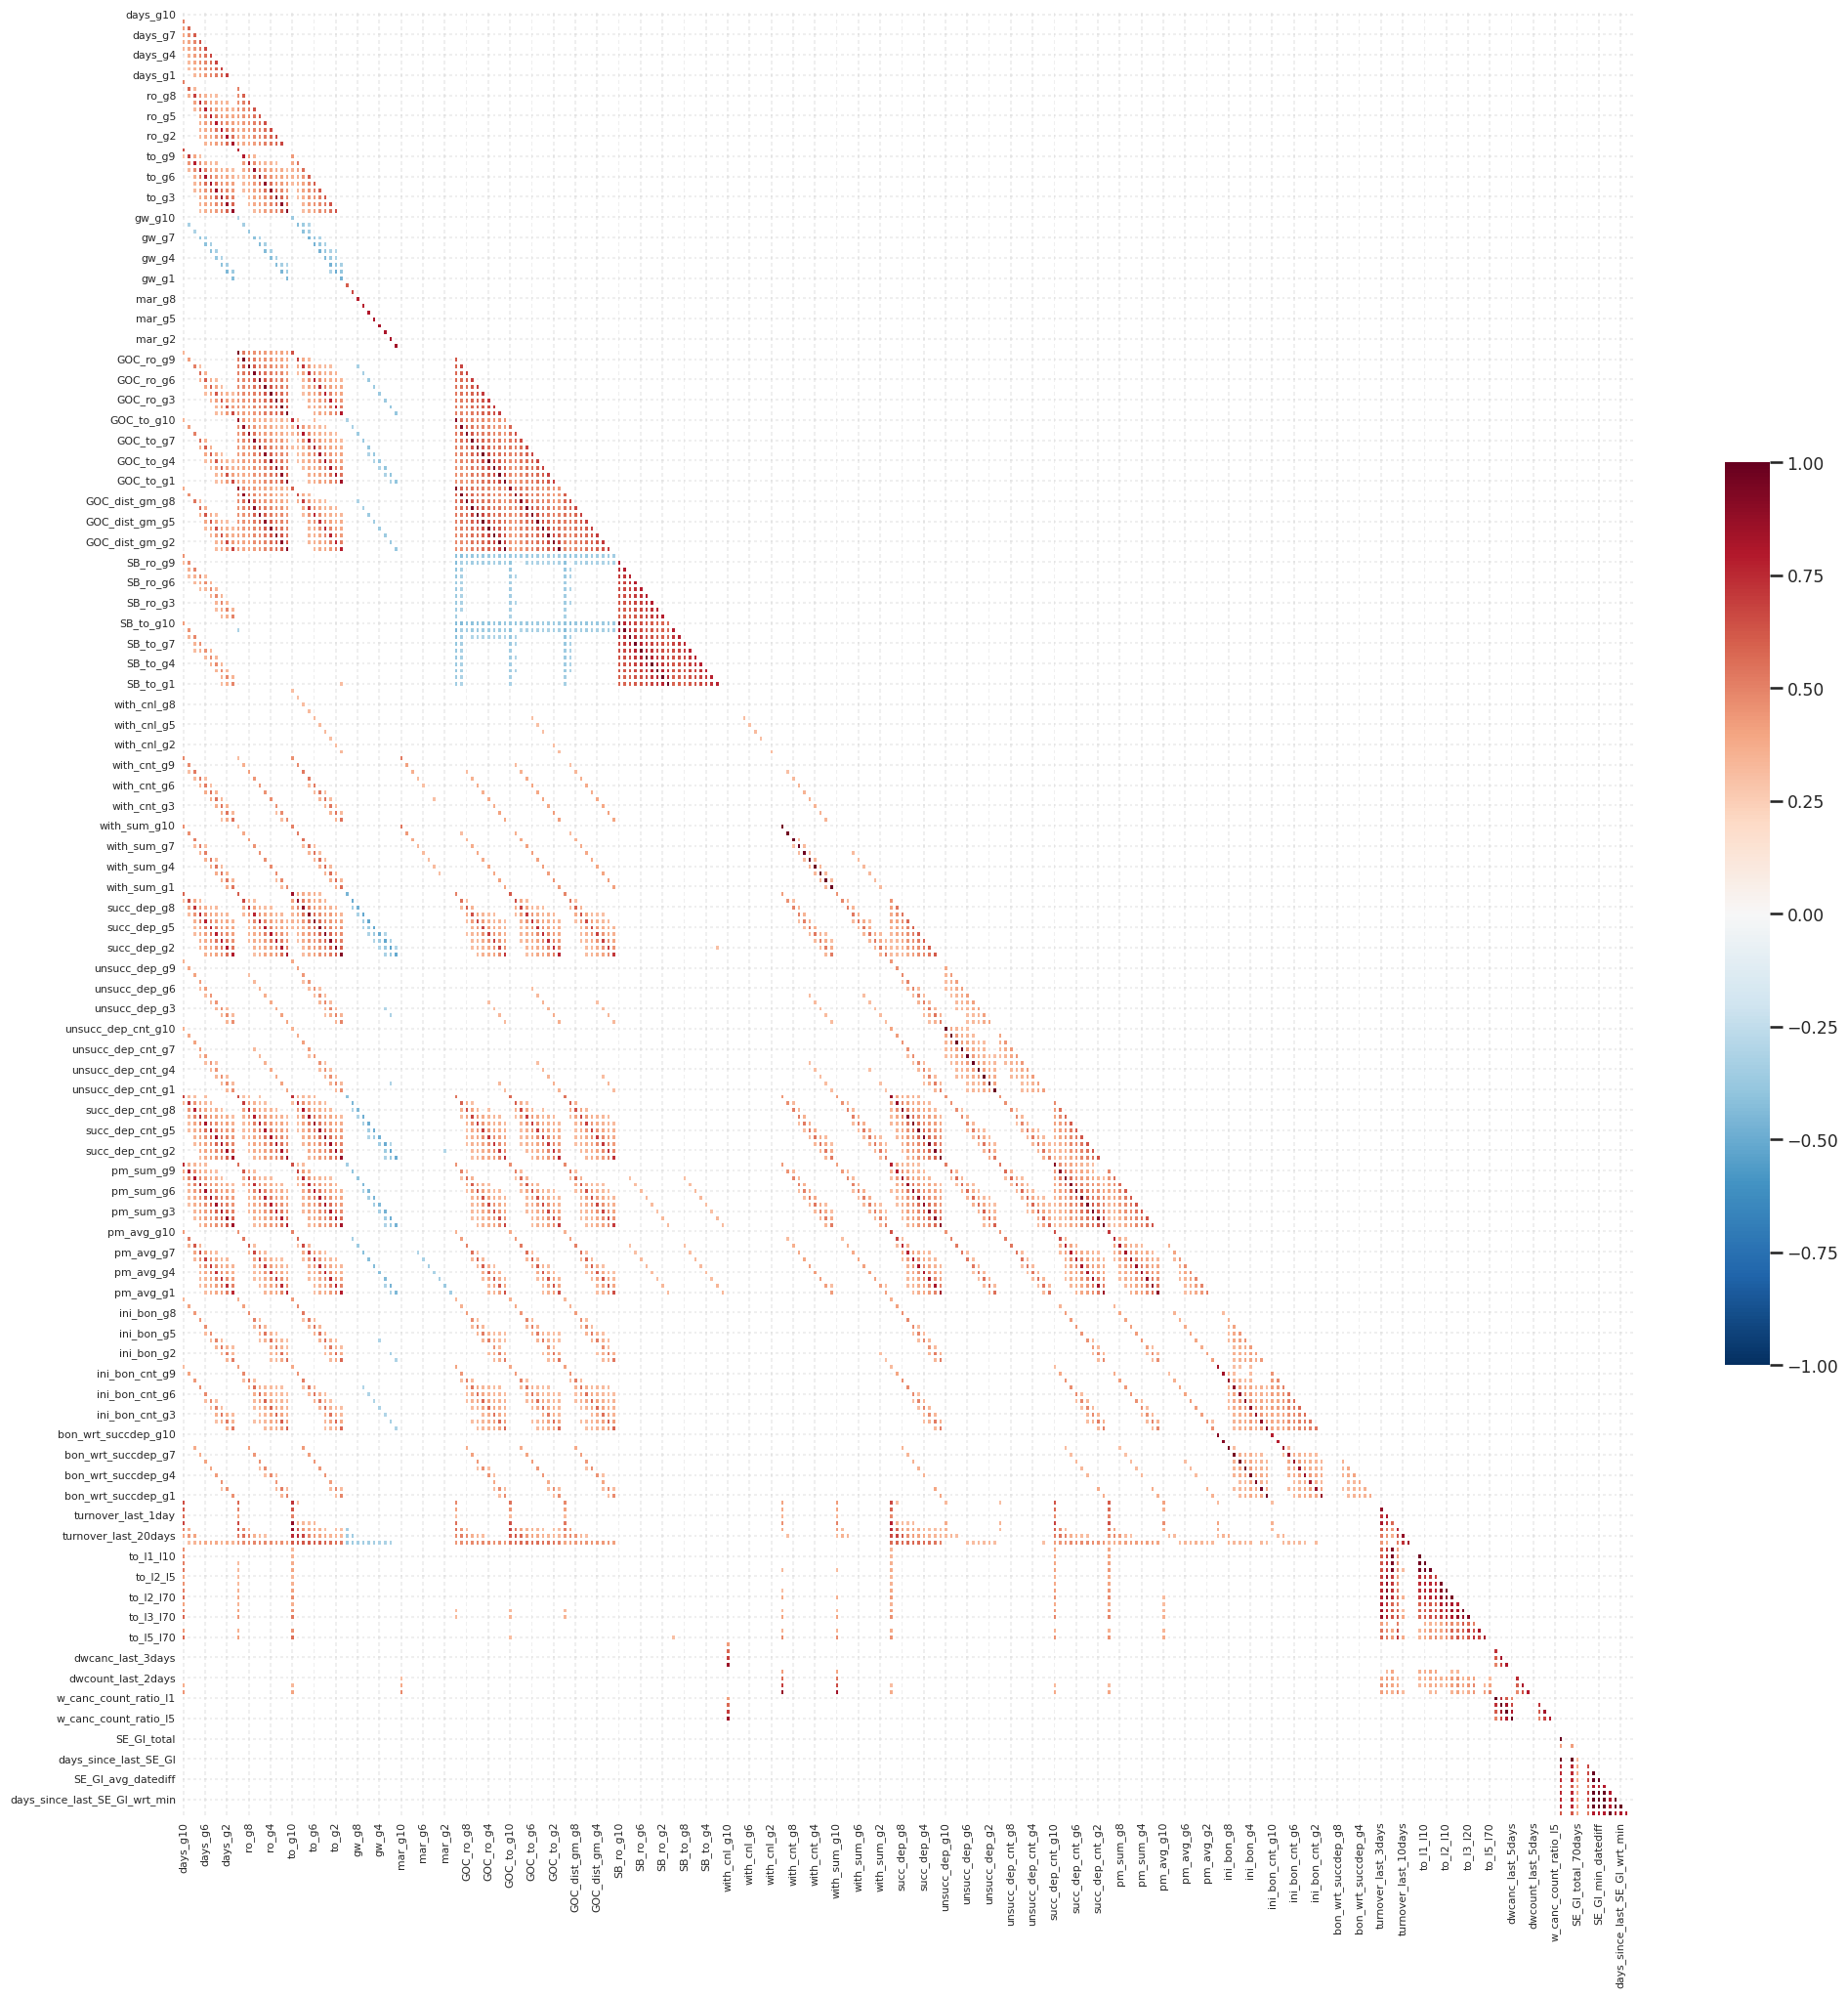

In [27]:
# Overview of the input feaatures' correlation

plt.figure(figsize=(24,24))
dfc = df[numeric_features].corr(method='spearman')
plot_heatmap(dfc, mask_threshold=0.3)

plt.xticks(size='xx-small')
plt.yticks(size='xx-small')
plt.tick_params(axis='both', length=0)

plt.show()

In [28]:
# Set diag and upper matrix to 0 
mask = np.zeros(dfc.shape).astype(bool)
mask[np.triu_indices_from(mask)] = True
dfc[mask] = 0

# Select the feature with the highest absolute correlation as an example
feature_highest_corr = dfc.abs().max().idxmax()

# Show the features with the highest absolute correlations
print(f'{feature_highest_corr} highest correlations:')
dfc.loc[:,'dwcanc_last_1day'].abs().sort_values(ascending=False).head()

dwcanc_last_1day highest correlations:


w_canc_count_ratio_l1    0.999982
dwcanc_last_2days        0.731470
w_canc_count_ratio_l2    0.731130
dwcanc_last_3days        0.612760
w_canc_count_ratio_l3    0.611988
Name: dwcanc_last_1day, dtype: float64

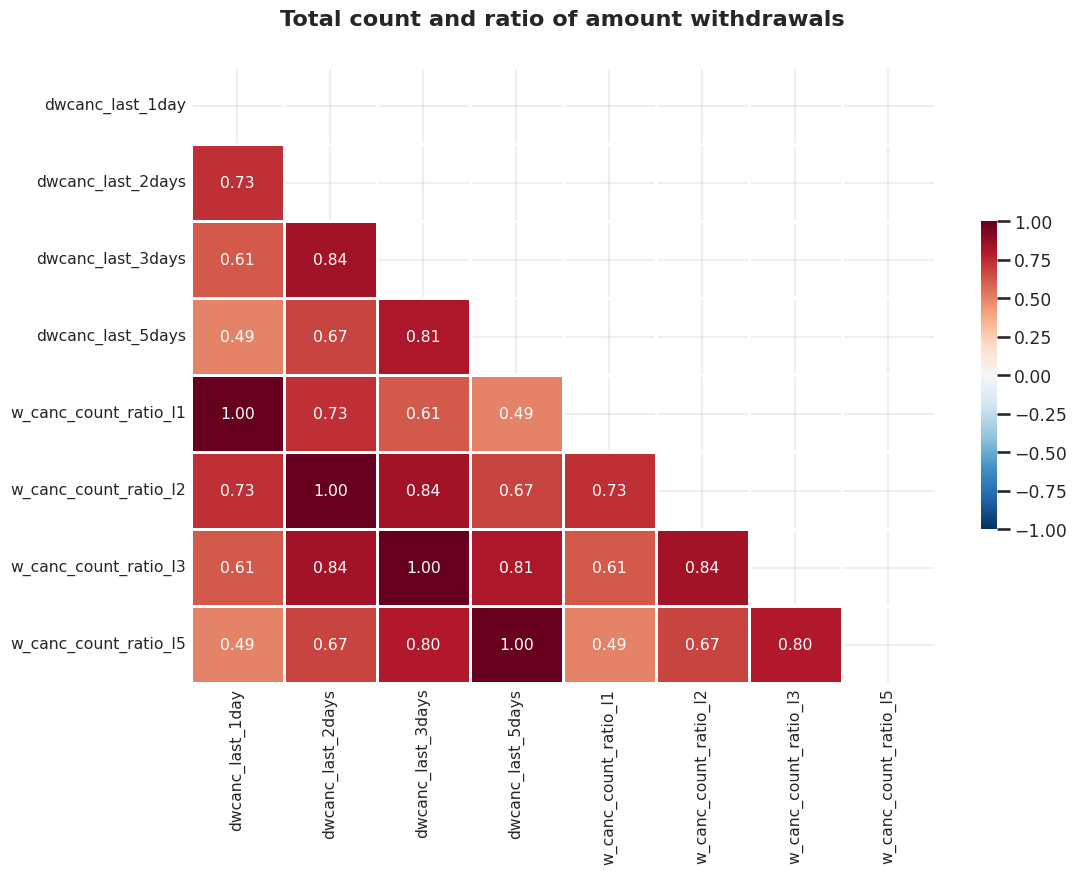

In [29]:
# Example with two specific feature types (Total amount count and ratio of withdrawals)
plt.figure(figsize=(12,8))
dfc = df.filter(regex='^dwcanc|^w_canc_count_ratio_').sort_values('dwcanc_last_1day').corr(method='spearman')
plot_heatmap(dfc, mask_threshold=0.3, annot=True, title='Total count and ratio of amount withdrawals')

plt.xticks(size='small')
plt.yticks(size='small')
plt.tick_params(axis='both', length=0)

plt.show()

Conclusion:
- There are multicollinearity
- Multicollinearity usually impacts linear models. Furthermore, more features mean more computational resources regardless of the model family, so we'll deal with them later :)

## Categorical features

In [30]:
contigency_table = pd.crosstab(df['country'], df['target'])
stats.chi2_contingency(contigency_table)

Chi2ContingencyResult(statistic=4.431764437020231, pvalue=0.6184581806678535, dof=6, expected_freq=array([[2.68128273e+04, 4.63172715e+02],
       [1.08191075e+04, 1.86892466e+02],
       [2.44771741e+02, 4.22825950e+00],
       [5.51080473e+03, 9.51952720e+01],
       [5.56585379e+03, 9.61462059e+01],
       [5.21000090e+01, 8.99990977e-01],
       [5.46853491e+03, 9.44650907e+01]]))

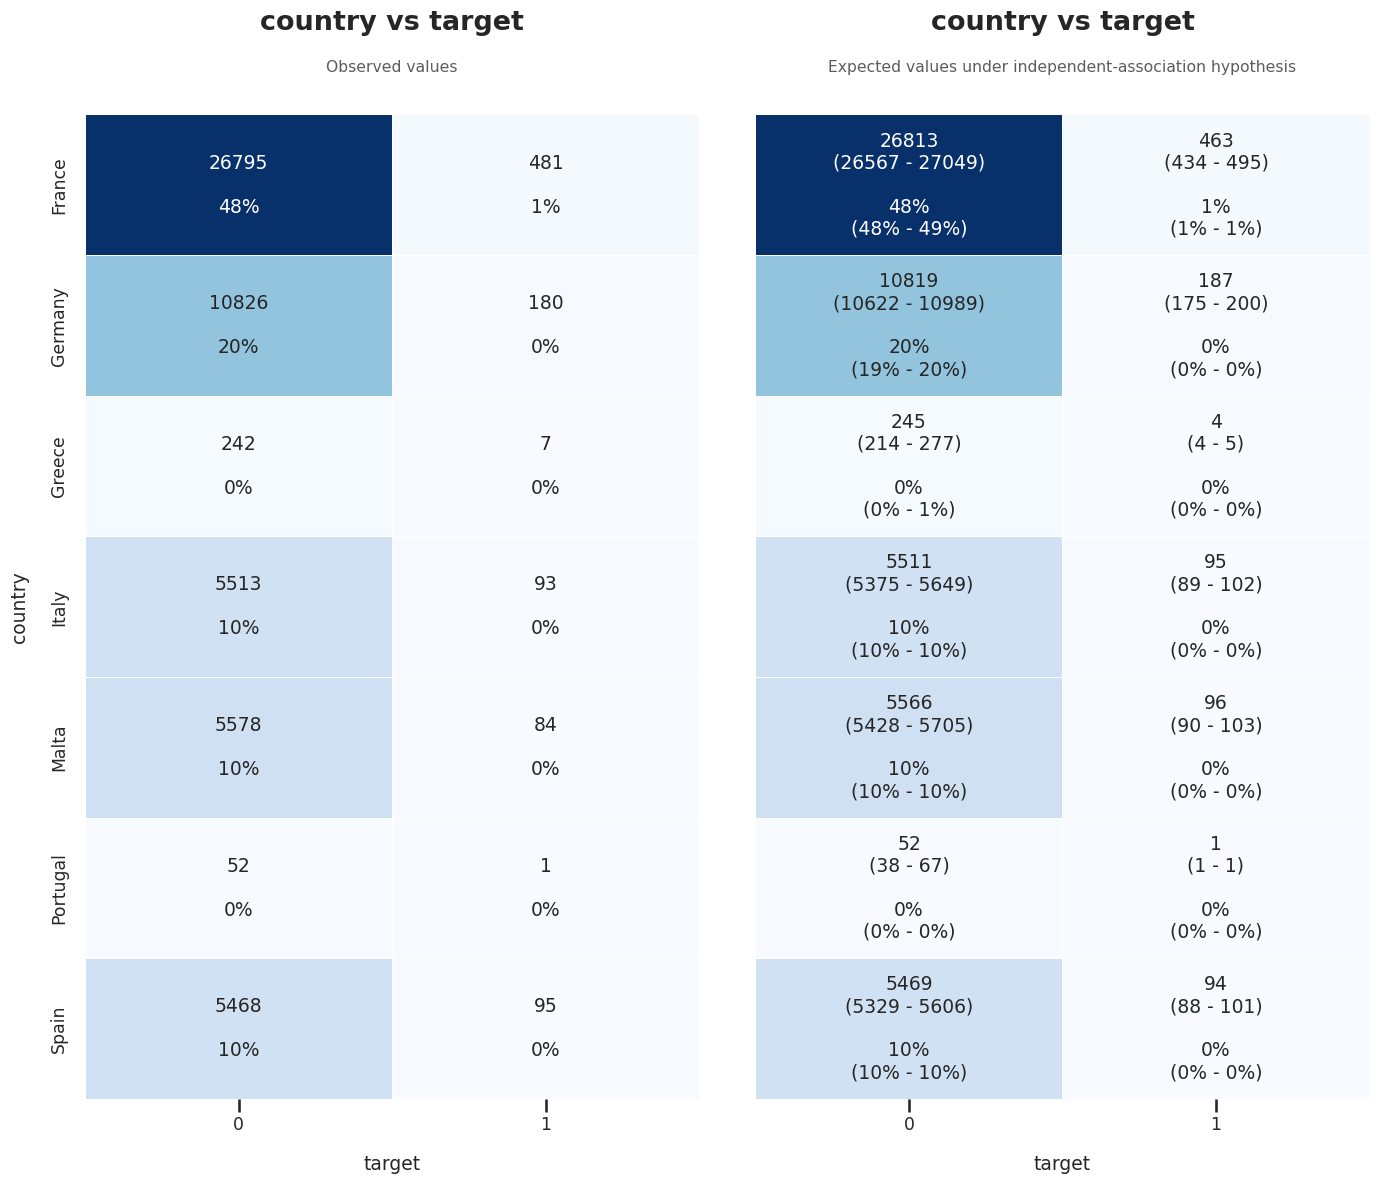

In [31]:
# Plot observed vs expected frequencies for country vs target categorical featurfeatures
plot_chi2_heatmap(df, 'country', 'target', bootstrap=True, n_bootstrap=1_000, figsize=(14,12))

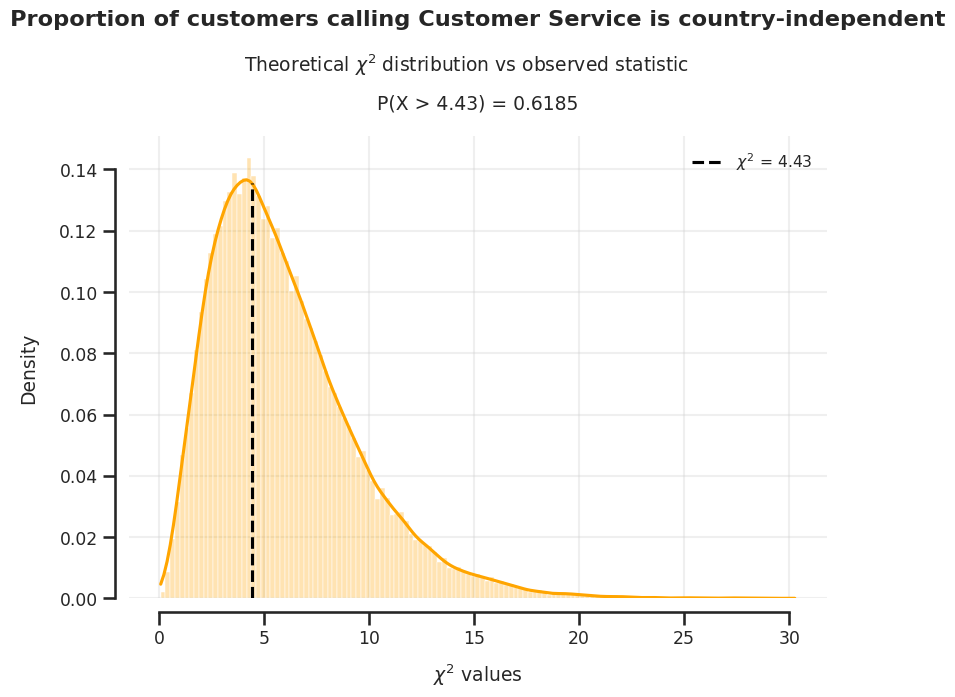

In [32]:
# Plot expected chi2 distribution vs observed value for country vs target
fig,ax = plt.subplots(figsize=(9,6))
plot_chi2(df, 'country', 'target', title='Proportion of customers calling Customer Service is country-independent', ax=ax)
fig.suptitle('Theoretical $\chi^2$ distribution vs observed statistic', size='medium', y=1.02)
plt.show()

Conclusion:
- There is no statistical association between the customer's country and calling the customer service (meaning that the observed proportions are quite similar to the expected one in a scenario of independence)

## Mutual Information

Mutual information (MI) between two random variables is a non-negative value, which measures the dependency between the variables. It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency.

In [33]:
# Prepare a preprocessor to compute the mutual information scores (it accepts only numerical data)
preprocessor = ColumnTransformer([
    ('numeric_processor', 'passthrough', numeric_features),
    ('categorical_processor', OneHotEncoder(drop='if_binary', sparse_output=False), categorical_features),
])

df_transformed = preprocessor.fit_transform(df)
df_transformed.columns = [col.split('__')[1] for col in df_transformed.columns]

# Specify discrete features to compute the MI scores
discrete_features = np.where(df_transformed.columns.str.startswith('country'))[0].tolist()

df_transformed.head()

,days_g10,days_g9,days_g8,days_g7,days_g6,days_g5,days_g4,days_g3,days_g2,days_g1,...,days_since_last_SE_GI_wrt_min,days_since_last_SE_GI_wrt_avg,days_since_last_SE_GI_wrt_std,country_France,country_Germany,country_Greece,country_Italy,country_Malta,country_Portugal,country_Spain
mk_CurrentCustomer,,,,,,,,,,,,,,,,,,,,,
10871718,2,0,2,3,3,3,2,5,4,4,...,-1,-1,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6818142,4,3,2,5,3,3,5,4,3,5,...,-1,-1,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
15585115,4,1,2,4,7,4,1,0,0,0,...,-1,-1,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12544601,2,3,7,4,1,2,0,2,0,0,...,-1,-1,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
14695611,5,1,4,4,3,4,4,3,4,3,...,-1,-1,-1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


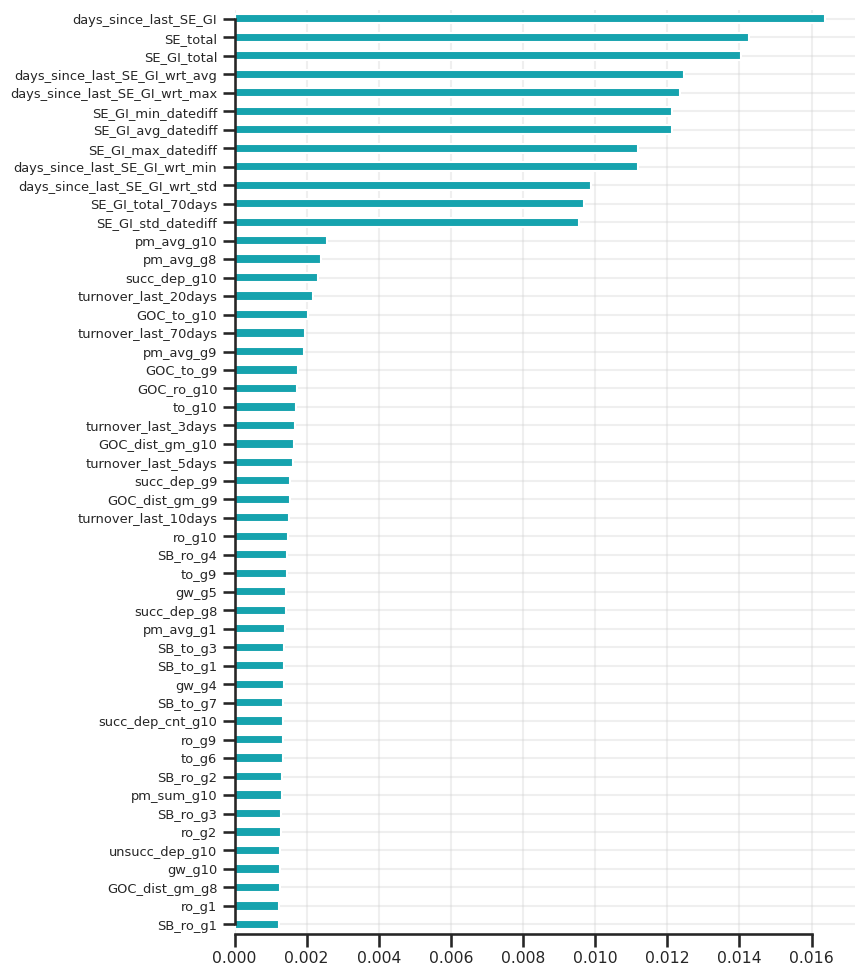

In [34]:
# Compute mutual information scores
mi_scores = mutual_info_classif(df_transformed, df.target, n_neighbors=10, discrete_features=discrete_features, random_state=42)

# Plot first top 50 scores
mi_scores = (
    pd.Series(mi_scores, index=df_transformed.columns)
    .sort_values(ascending=False)
)

mi_scores.sort_values(ascending=True).tail(50).plot.barh(figsize=(8,12))
plt.yticks(size='x-small')
plt.xticks(size='small')
sns.despine(trim=True);

Conclusion:
- Through the MI analysis, it's possible to notice the influence of the top 12 features
- The most important features are somehow related to gambling issues or self-exclusion